# Figures and Tables

In [1]:
import os

# Load relevant external modules
import torch
try:
    import biotite
    import mdtraj
    import torch_geometric
except:

    TORCH_VERSION = torch.__version__.split('+')[0]
    CUDA_VERSION = 'cu' + torch.__version__.replace('.', '')

    !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH_VERSION}+{CUDA_VERSION}.html
    !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH_VERSION}+{CUDA_VERSION}.html
    !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH_VERSION}+{CUDA_VERSION}.html
    !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH_VERSION}+{CUDA_VERSION}.html
    !pip install torch-geometric biotite==0.41.2 mdtraj

In [2]:
DEVICE: str = "cpu"  # "cpu", "cuda", "mps"
BATCH_SIZE: int = 64

# Download repo if notebook is taken out of context (e.g. by colab)
if not os.path.exists('likelihoods_esm_if.py'):
    !git clone https://github.com/MachineLearningLifeScience/inverse_folding_free_energies tmp_clone
    !mv tmp_clone/* .
    !rm -rf tmp_clone

### Fetch experimental data

In [3]:
import os
if not os.path.exists('data'):
    os.mkdir("data")
%cd data
if not os.path.exists('data_dms'):
    !curl https://sid.erda.dk/share_redirect/eRmsTXG7xt/data_dms.tar.gz | tar xz
if not os.path.exists('data_guerois'):
    !curl https://sid.erda.dk/share_redirect/eRmsTXG7xt/data_guerois.tar.gz | tar xz
if not os.path.exists('data_protein_g'):
    !curl https://sid.erda.dk/share_redirect/eRmsTXG7xt/data_protein_g.tar.gz | tar xz

if not os.path.exists('data_dms/mcmc_samples_unfolded'):
    !curl https://sid.erda.dk/share_redirect/eRmsTXG7xt/data_dms_mcmc_unfolded.tar.gz | tar xz
if not os.path.exists('data_guerois/mcmc_samples_unfolded'):
    !curl https://sid.erda.dk/share_redirect/eRmsTXG7xt/data_guerois_mcmc_unfolded.tar.gz | tar xz
if not os.path.exists('data_protein_g/mcmc_samples_unfolded'):
    !curl https://sid.erda.dk/share_redirect/eRmsTXG7xt/data_protein_g_mcmc_unfolded.tar.gz | tar xz
if not os.path.exists('data_protein_g/bioemu_relaxed'):
    !curl https://sid.erda.dk/share_redirect/eRmsTXG7xt/data_protein_g_bioemu.tar.gz | tar xz

if not os.path.exists('data_megascale'):
    !curl https://sid.erda.dk/share_redirect/eRmsTXG7xt/data_megascale.tar.gz | tar xz


%cd ..

/Users/wb/projects/inverse_folding_free_energies/git_repo/data
/Users/wb/projects/inverse_folding_free_energies/git_repo


/Users/wb/opt/miniconda3/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Read in experimental data

In [4]:
import glob
import pandas as pd

# Read in data
ddg_data_dict = {
    "dms": pd.read_csv("data/data_dms/ddgs_parsed.csv"),
    "protein_g": pd.read_csv("data/data_protein_g/ddgs_parsed.csv"),
    "guerois": pd.read_csv("data/data_guerois/ddgs_parsed.csv"),
}
pdb_dict = {}
for ddg_key in ddg_data_dict:
    pdb_dict.update({os.path.split(path)[-1].split('_')[0]: path for path in glob.glob(f"data/data_{ddg_key}/pdbs_cleaned/*.pdb")})

md_pdb_dict = {}
# FIXME: Hardcoding residue index offset here. 
md_pdb_index_offsets = {'guerois':{'1A2P':2, '1BF4':1, '1CEY': 1, '1FMK':81, '1HFZ': -1, '1HZ6': -3, '1LMB': 5, '1MJC': 1, '1QHE': 1, '1SHF': 83, '1SHG': 5, '1STN': 5, '1TEN': 801, '2CI2': 18}} 
for ddg_key in ddg_data_dict:
    md_pdb_dict[ddg_key] = {}
    # Reading in at X000ps intervals. Including MD starting point.
    for path in sorted(glob.glob(f"data/data_{ddg_key}/molecular_dynamics_npt/pdbs_cleaned/*[_1]?000ps_clean.pdb")) + glob.glob(f"data/data_{ddg_key}/pdbs_cleaned/*.pdb"):
        pdb_id = os.path.split(path)[-1].split('_')[0].upper()

        if pdb_id not in md_pdb_dict[ddg_key]:
            md_pdb_dict[ddg_key][pdb_id] = []
        md_pdb_dict[ddg_key][pdb_id].append(path)

unfolded_pdb_dict = {}
for ddg_key in ddg_data_dict:
    unfolded_pdb_dict[ddg_key] = {}
    for path in sorted(glob.glob(f"data/data_{ddg_key}/mcmc_samples_unfolded/samples_????_*")):

        # Discard _mt simulations - we'll stick with importance sampling just as in the folded state
        if '_mt' in os.path.split(path)[-1]:
            continue

        pdb_id = os.path.split(path)[-1].split('_')[1].upper()
        variant = os.path.split(path)[-1].split('_')[2]
        if pdb_id not in unfolded_pdb_dict[ddg_key]:
            unfolded_pdb_dict[ddg_key][pdb_id] = {}

        for filename in glob.glob(f"{path}/*.pdb"):
            filename = filename.replace(variant, '{}')
            unfolded_pdb_dict[ddg_key][pdb_id][filename] = True

uniprot_seq_dict = {
    '1D5R': 'MTAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVYRNNIDDVVRFLDSKHKNHYKIYNLCAERHYDTAKFNCRVAQYPFEDHNPPQLELIKPFCEDLDQWLSEDDNHVAAIHCKAGKGRTGVMICAYLLHRGKFLKAQEALDFYGEVRTRDKKGVTIPSQRRYVYYYSYLLKNHLDYRPVALLFHKMMFETIPMFSGGTCNPQFVVCQLKVKIYSSNSGPTRREDKFMYFEFPQPLPVCGDIKVEFFHKQNKMLKKDKMFHFWVNTFFIPGPEETSEKVENGSLCDQEIDSICSIERADNDKEYLVLTLTKNDLDKANKDKANRYFSPNFKVKLYFTKTVEEPSNPEASSSTSVTPDVSDNEPDHYRYSDTTDSDPENEPFDEDQHTQITKV',
    '2H11': 'MDGTRTSLDIEEYSDTEVQKNQVLTLEEWQDKWVNGKTAFHQEQGHQLLKKHLDTFLKGKSGLRVFFPLCGKAVEMKWFADRGHSVVGVEISELGIQEFFTEQNLSYSEEPITEIPGTKVFKSSSGNISLYCCSIFDLPRTNIGKFDMIWDRGALVAINPGDRKCYADTMFSLLGKKFQYLLCVLSYDPTKHPGPPFYVPHAEIERLFGKICNIRCLEKVDAFEERHKSWGIDCLFEKLYLLTEK',
    '171L': 'MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSALDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYKNL',
    '1A2P': 'AQVINTFDGVADYLQTYHKLPDNYITKSEAQALGWVASKGNLADVAPGKSIGGDIFSNREGKLPGKSGRTWREADINYTSGFRNSDRILYSSDWLIYKTTDHYQTFTKIR',
    '1ANF': 'KIEEGKLVIWINGDKGYNGLAEVGKKFEKDTGIKVTVEHPDKLEEKFPQVAATGDGPDIIFWAHDRFGGYAQSGLLAEITPDKAFQDKLYPFTWDAVRYNGKLIAYPIAVEALSLIYNKDLLPNPPKTWEEIPALDKELKAKGKSALMFNLQEPYFTWPLIAADGGYAFKYENGKYDIKDVGVDNAGAKAGLTFLVDLIKNKHMNADTDYSIAEAAFNKGETAMTINGPWAWSNIDTSKVNYGVTVLPTFKGQPSKPFVGVLSAGINAASPNKELAKEFLENYLLTDEGLEAVNKDKPLGAVALKSYEEELAKDPRIAATMENAQKGEIMPNIPQMSAFWYAVRTAVINAASGRQTVDEALKDAQTRITK',
    '1BF4': 'ATVKFKYKGEEKEVDISKIKKVWRVGKMISFTYDEGGGKTGRGAVSEKDAPKELLQMLEKQKK',
    '1BPI': 'RPDFCLEPPYTGPCKARIIRYFYNAKAGLCQTFVYGGCRAKRNNFKSAEDCMRTCGGA',
    '1BVC': 'VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQG',
    '1CEY': 'ADKELKFLVVDDFSTMRRIVRNLLKELGFNNVEEAEDGVDALNKLQAGGYGFVISDWNMPNMDGLELLKTIRADGAMSALPVLMVTAEAKKENIIAAAQAGASGYVVKPFTAATLEEKLNKIFEKLGM',
    '1CSP': 'MLEGKVKWFNSEKGFGFIEVEGQDDVFVHFSAIQGEGFKTLEEGQAVSFEIVEGNRGPQAANVTKEA',
    '1CYO': 'SKAVKYYTLEEIQKHNNSKSTWLILHYKVYDLTKFLEEHPGGEEVLREQAGGDATENFEDVGHSTDARELSKTFIIGELHPDDRSKITKPSES',
    '1DYJ': 'MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLDKPVIMGRHTWESIGRPLPGRKNIILSSQPGTDDRVTWVKSVDEAIAACGDVPEIMVIGGGRVYEQFLPKAQKLYLTHIDAEVEGDTHFPDYEPDDWESVFSEFHDADAQNSHSYCFEILERR',
    '1FKB': 'GVQVETISPGDGRTFPKRGQTCVVHYTGMLEDGKKFDSSRDRNKPFKFMLGKQEVIRGWEEGVAQMSVGQRAKLTISPDYAYGATGHPGIIPPHATLVFDVELLKLE',
    '1FMK': 'MVTTFVALYDYESRTETDLSFKKGERLQIVNNTEGDWWLAHSLSTGQTGYIPSNYVAPSDSIQAEEWYFGKITRRESERLLLNAENPRGTFLVRESETTKGAYCLSVSDFDNAKGLNVKHYKIRKLDSGGFYITSRTQFNSLQQLVAYYSKHADGLCHRLTTVCPTSKPQTQGLAKDAWEIPRESLRLEVKLGQGCFGEVWMGTWNGTTRVAIKTLKPGTMSPEAFLQEAQVMKKLRHEKLVQLYAVVSEEPIYIVTEYMSKGSLLDFLKGETGKYLRLPQLVDMAAQIASGMAYVERMNYVHRDLRAANILVGENLVCKVADFGLARLIEDNEYTARQGAKFPIKWTAPEAALYGRFTIKSDVWSFGILLTELTTKGRVPYPGMVNREVLDQVERGYRMPCPPECPESLHDLMCQCWRKEPEERPTFEYLQAFLEDYFTSTEPQYQPGENL',
    '1FXA': 'ATFKVTLINEAEGTKHEIEVPDDEYILDAAEEQGYDLPFSCRAGACSTCAGKLVSGTVDQSDQSFLDDDQIEAGYVLTCVAYPTSDVVIQTHKEEDLY',
    '1HFZ': 'MEQLTKCEVFRELKDLKGYGGVSLPEWVCTTFHTSGYDTQAIVQNNDSTEYGLFQINNKIWCKDDQNPHSSNICNISCDKFLDDDLTDDIVCVKKILDKVGINYWLAHKALCSEKLDQWLCEKL',
    '1HTI': 'APSRKFFVGGNWKMNGRKQSLGELIGTLNAAKVPADTEVVCAPPTAYIDFARQKLDPKIAVAAQNCYKVTNGAFTGEISPGMIKDCGATWVVLGHSERRHVFGESDELIGQKVAHALAEGLGVIACIGEKLDEREAGITEKVVFEQTKVIADNVKDWSKVVLAYEPVWAIGTGKTATPQQAQEVHEKLRGWLKSNVSDAVAQSTRIIYGGSVTGATCKELASQPDVDGFLVGGASLKPEFVDIINAKQ',
    '1HZ6': 'MHHHHHHAMEEVTIKANLIFANGSTQTAEFKGTFEKATSEAYAYADTLKKDNGEWTVDVADKGYTLNIKFAG',
    '1IFC': 'MAFDGTWKVDRNENYEKFMEKMGINVVKRKLGAHDNLKLTITQEGNKFTVKESSNFRNIDVVFELGVDFAYSLADGTELTGTWTMEGNKLVGKFKRVDNGKELIAVREISGNELIQTYTYEGVEAKRIFKKE',
    '1IOB': 'APVRSLNCTLRDSQQKSLVMSGPYELKALHLQGQDMEQQVVFSMSFVQGEESNDKIPVALGLKEKNLYLSCVLKDDKPTLQLESVDPKNYPKKKMEKRFVFNKIEINNKLEFESAQFPNWYISTSQAENMPVFLGGTKGGQDITDFTMQFVSS',
    '1L63': 'MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYKNL',
    '1LMB': 'STKKKPLTQEQLEDARRLKAIYEKKKNELGLSQESVADKMGMGQSGVGALFNGINALNAYNAALLAKILKVSVEEFSPSIAREIYEMYEAVS',
    '1MJC': 'SGKMTGIVKWFNADKGFGFITPDDGSKDVFVHFSAIQNDGYKSLDEGQKVSFTIESGAKGPAAGNVTSL',
    '1PGA': 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE',
    '1QHE': 'KKIGLFYGTQTGKTESVAEIIRDEFGNDVVTLHDVSQAEVTDLNDYQYLIIGCPTWNIGELQSDWEGLYSELDDVDFNGKLVAYFGTGDQIGYADNFQDAIGILEEKISQRGGKTVGYWSTDGYDFNDSKALRNGKFVGLALDEDNQSDLTDDRIKSWVAQLKSEFGL',
    '1REX': 'KVFERCELARTLKRLGMDGYRGISLANWMCLAKWESGYNTRATNYNAGDRSTDYGIFQINSRYWCNDGKTPGAVNACHLSCSALLQDNIADAVACAKRVVRDPQGIRAWVAWRNRCQNRDVRQYVQGCGV',
    '1RN1': 'ACDYTCGSNCYSSSDVSTAQAAGYQLHEDGETVGSNSYPHKYNNYEGFDFSVSSPYYEWPILSSGDVYSGGSPGADRVVFNENNQLAGVITHTGASGNNFVECT',
    '1SHF': 'MGCVQCKDKEATKLTEERDGSLNQSSGYRYGTDPTPQHYPSFGVTSIPNYNNFHAAGGQGLTVFGGVNSSSHTGTLRTRGGTGVTLFVALYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGETGYIPSNYVAPVDSIQAEEWYFGKLGRKDAERQLLSFGNPRGTFLIRESETTKGAYSLSIRDWDDMKGDHVKHYKIRKLDNGGYYITTRAQFETLQQLVQHYSERAAGLCCRLVVPCHKGMPRLTDLSVKTKDVWEIPRESLQLIKRLGNGQFGEVWMGTWNGNTKVAIKTLKPGTMSPESFLEEAQIMKKLKHDKLVQLYAVVSEEPIYIVTEYMNKGSLLDFLKDGEGRALKLPNLVDMAAQVAAGMAYIERMNYIHRDLRSANILVGNGLICKIADFGLARLIEDNEYTARQGAKFPIKWTAPEAALYGRFTIKSDVWSFGILLTELVTKGRVPYPGMNNREVLEQVERGYRMPCPQDCPISLHELMIHCWKKDPEERPTFEYLQSFLEDYFTATEPQYQPGENL',
    '1SHG': 'MDETGKELVLALYDYQEKSPREVTMKKGDILTLLNSTNKDWWKVEVNDRQGFVPAAYVKKLD',
    '1STN': 'ATSTKKLHKEPATLIKAIDGDTVKLMYKGQPMTFRLLLVDTPETKHPKKGVEKYGPEASAFTKKMVENAKKIEVEFDKGQRTDKYGRGLAYIYADGKMVNEALVRQGLAKVAYVYKPNNTHEQHLRKSEAQAKKEKLNIWSEDNADSGQ',
    '1SUP': 'AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAGGASMVPSETNPFQDNNSHGTHVAGTVAALNNSIGVLGVAPSASLYAVKVLGADGSGQYSWIINGIEWAIANNMDVINMSLGGPSGSAALKAAVDKAVASGVVVVAAAGNEGTSGSSSTVGYPGKYPSVIAVGAVDSSNQRASFSSVGPELDVMAPGVSIQSTLPGNKYGAYNGTSMASPHVAGAAALILSKHPNWTNTQVRSSLENTTTKLGDSFYYGKGLINVQAAAQ',
    '1TEN': 'MGAMTQLLAGVFLAFLALATEGGVLKKVIRHKRQSGVNATLPEENQPVVFNHVYNIKLPVGSQCSVDLESASGEKDLAPPSEPSESFQEHTVDGENQIVFTHRINIPRRACGCAAAPDVKELLSRLEELENLVSSLREQCTAGAGCCLQPATGRLDTRPFCSGRGNFSTEGCGCVCEPGWKGPNCSEPECPGNCHLRGRCIDGQCICDDGFTGEDCSQLACPSDCNDQGKCVNGVCICFEGYAGADCSREICPVPCSEEHGTCVDGLCVCHDGFAGDDCNKPLCLNNCYNRGRCVENECVCDEGFTGEDCSELICPNDCFDRGRCINGTCYCEEGFTGEDCGKPTCPHACHTQGRCEEGQCVCDEGFAGVDCSEKRCPADCHNRGRCVDGRCECDDGFTGADCGELKCPNGCSGHGRCVNGQCVCDEGYTGEDCSQLRCPNDCHSRGRCVEGKCVCEQGFKGYDCSDMSCPNDCHQHGRCVNGMCVCDDGYTGEDCRDRQCPRDCSNRGLCVDGQCVCEDGFTGPDCAELSCPNDCHGQGRCVNGQCVCHEGFMGKDCKEQRCPSDCHGQGRCVDGQCICHEGFTGLDCGQHSCPSDCNNLGQCVSGRCICNEGYSGEDCSEVSPPKDLVVTEVTEETVNLAWDNEMRVTEYLVVYTPTHEGGLEMQFRVPGDQTSTIIQELEPGVEYFIRVFAILENKKSIPVSARVATYLPAPEGLKFKSIKETSVEVEWDPLDIAFETWEIIFRNMNKEDEGEITKSLRRPETSYRQTGLAPGQEYEISLHIVKNNTRGPGLKRVTTTRLDAPSQIEVKDVTDTTALITWFKPLAEIDGIELTYGIKDVPGDRTTIDLTEDENQYSIGNLKPDTEYEVSLISRRGDMSSNPAKETFTTGLDAPRNLRRVSQTDNSITLEWRNGKAAIDSYRIKYAPISGGDHAEVDVPKSQQATTKTTLTGLRPGTEYGIGVSAVKEDKESNPATINAATELDTPKDLQVSETAETSLTLLWKTPLAKFDRYRLNYSLPTGQWVGVQLPRNTTSYVLRGLEPGQEYNVLLTAEKGRHKSKPARVKASTEQAPELENLTVTEVGWDGLRLNWTAADQAYEHFIIQVQEANKVEAARNLTVPGSLRAVDIPGLKAATPYTVSIYGVIQGYRTPVLSAEASTGETPNLGEVVVAEVGWDALKLNWTAPEGAYEYFFIQVQEADTVEAAQNLTVPGGLRSTDLPGLKAATHYTITIRGVTQDFSTTPLSVEVLTEEVPDMGNLTVTEVSWDALRLNWTTPDGTYDQFTIQVQEADQVEEAHNLTVPGSLRSMEIPGLRAGTPYTVTLHGEVRGHSTRPLAVEVVTEDLPQLGDLAVSEVGWDGLRLNWTAADNAYEHFVIQVQEVNKVEAAQNLTLPGSLRAVDIPGLEAATPYRVSIYGVIRGYRTPVLSAEASTAKEPEIGNLNVSDITPESFNLSWMATDGIFETFTIEIIDSNRLLETVEYNISGAERTAHISGLPPSTDFIVYLSGLAPSIRTKTISATATTEALPLLENLTISDINPYGFTVSWMASENAFDSFLVTVVDSGKLLDPQEFTLSGTQRKLELRGLITGIGYEVMVSGFTQGHQTKPLRAEIVTEAEPEVDNLLVSDATPDGFRLSWTADEGVFDNFVLKIRDTKKQSEPLEITLLAPERTRDITGLREATEYEIELYGISKGRRSQTVSAIATTAMGSPKEVIFSDITENSATVSWRAPTAQVESFRITYVPITGGTPSMVTVDGTKTQTRLVKLIPGVEYLVSIIAMKGFEESEPVSGSFTTALDGPSGLVTANITDSEALARWQPAIATVDSYVISYTGEKVPEITRTVSGNTVEYALTDLEPATEYTLRIFAEKGPQKSSTITAKFTTDLDSPRDLTATEVQSETALLTWRPPRASVTGYLLVYESVDGTVKEVIVGPDTTSYSLADLSPSTHYTAKIQALNGPLRSNMIQTIFTTIGLLYPFPKDCSQAMLNGDTTSGLYTIYLNGDKAEALEVFCDMTSDGGGWIVFLRRKNGRENFYQNWKAYAAGFGDRREEFWLGLDNLNKITAQGQYELRVDLRDHGETAFAVYDKFSVGDAKTRYKLKVEGYSGTAGDSMAYHNGRSFSTFDKDTDSAITNCALSYKGAFWYRNCHRVNLMGRYGDNNHSQGVNWFHWKGHEHSIQFAEMKLRPSNFRNLEGRRKRA',
    '1WQ5': 'MERYESLFAQLKERKEGAFVPFVTLGDPGIEQSLKIIDTLIEAGADALELGIPFSDPLADGPTIQNATLRAFAAGVTPAQCFEMLALIRQKHPTIPIGLLMYANLVFNKGIDEFYAQCEKVGVDSVLVADVPVEESAPFRQAALRHNVAPIFICPPNADDDLLRQIASYGRGYTYLLSRAGVTGAENRAALPLNHLVAKLKEYNAAPPLQGFGISAPDQVKAAIDAGAAGAISGSAIVKIIEQHINEPEKMLAALKVFVQPMKAATRS',
    '1YCC': 'MTEFKAGSAKKGATLFKTRCLQCHTVEKGGPHKVGPNLHGIFGRHSGQAEGYSYTDANIKKNVLWDENNMSEYLTNPKKYIPGTKMAFGGLKKEKDRNDLITYLKKACE',
    '219L': 'MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYKNL',
    '2BQA': 'KVFERCELARTLKRLGMDGYRGISLANWMCLAKWESGYNTRATNYNAGDRSTDYGIFQINSRYWCNDGKTPGAVNAAHLSCSALLQDNIADAVAAAKRVVRDPQGIRAWVAWRNRCQNRDVRQYVQGCGV',
    '2CI2': 'SSVEKKPEGVNTGAGDRHNLKTEWPELVGKSVEEAKKVILQDKPEAQIIVLPVGTIVTMEYRIDRVRLFVDKLDNIAEVPRVG',
    '2LZM': 'MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSELDKAIGRNCNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRCALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYKNL',
    '2WSY': 'MERYENLFAQLNDRREGAFVPFVTLGDPGIEQSLKIIDTLIDAGADALELGVPFSDPLADGPTIQNANLRAFAAGVTPAQCFEMLALIREKHPTIPIGLLMYANLVFNNGIDAFYARCEQVGVDSVLVADVPVEESAPFRQAALRHNIAPIFICPPNADDDLLRQVASYGRGYTYLLSRSGVTGAENRGALPLHHLIEKLKEYHAAPALQGFGISSPEQVSAAVRAGAAGAISGSAIVKIIEKNLASPKQMLAELRSFVSAMKAASRA',
    '3HHR': 'FPTIPLSRLFDNAMLRAHRLHQLAFDTYQEFEEAYIPKEQKYSFLQNPQTSLCFSESIPTPSNREETQQKSNLELLRISLLLIQSWLEPVQFLRSVFANSLVYGASDSNVYDLLKDLEEGIQTLMGRLEDGSPRTGQIFKQTYSKFDTNSHNDDALLKNYGLLYCFRKDMDKVETFLRIVQCRSVEGSCG',
    '4LYZ': 'KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKKIVSDGNGMNAWVAWRNRCKGTDVQAWIRGCRL',
}

### Retrieve AA frequencies

In [5]:
try:
    from Bio import SeqIO
except:
    !pip install biopython
    from Bio import SeqIO

def get_proteome_reference_aa_dist(fasta_filename):
    """Retrieve amino acid statistics from FASTA file"""

    possible_aa = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"]
    stats = {}
    total = 0
    with open(fasta_filename) as handle:
        for record in SeqIO.parse(handle, "fasta"):
            for aa in str(record.seq):
                if aa not in possible_aa:
                    continue
                if aa not in stats:
                    stats[aa] = 0
                stats[aa] += 1
                total += 1
        for aa in stats:
            stats[aa] /= total
    return stats


def get_intrinsically_disorded_aa_dist():
    """Return amino acid frequences extracted from intrinsically disordered regions"""
    return {
        "A": 0.06856891151135473,
        "C": 0.03244909945184025,
        "D": 0.058633516053249804,
        "E": 0.09025058731401722,
        "F": 0.023296789350039156,
        "G": 0.06528974158183241,
        "H": 0.009641738449490995,
        "I": 0.04113645262333594,
        "K": 0.07845536413469067,
        "L": 0.07852877838684416,
        "M": 0.018794048551292093,
        "N": 0.04023101018010963,
        "P": 0.07703602192638997,
        "Q": 0.047841620986687546,
        "R": 0.0668559122944401,
        "S": 0.07938527799530148,
        "T": 0.05716523101018011,
        "V": 0.04835552075176194,
        "W": 0.003205755677368833,
        "Y": 0.014878621769772905,
    }


if not os.path.exists("UP000005640_9606.fasta"):
    !wget https://sid.erda.dk/share_redirect/eRmsTXG7xt/UP000005640_9606.fasta

human_proteome_aa_dist = get_proteome_reference_aa_dist("UP000005640_9606.fasta")
idp_aa_stats = get_intrinsically_disorded_aa_dist()

### Likelihood evaluation code 

In [6]:
def calculate_single_sample_results(protein_experiment_dict, likelihood_evaluator, output_file_prefixer, 
                                    pdb_dict=md_pdb_dict, pdb_index_offsets=md_pdb_index_offsets, use_cache=False, batch_size=BATCH_SIZE):
    """Calculate inverse-folding likelihoods using only a single structural sample for the folded state"""
    results_single_sample = {}
    for ddg_data_key, df in protein_experiment_dict.items():

        dfs = []
        for pdb_id, grp in df.groupby('pdbid'):

            chain_id = grp['chainid'].iloc[0]
            structure_filename = pdb_dict[pdb_id]

            dfs.append(likelihood_evaluator(grp, structure_filename, pdb_id, use_cache=use_cache, batch_size=batch_size,
                                            output_file_prefix=output_file_prefixer(ddg_data_key, structure_filename)))

            dfs[-1].insert(0, 'filename', structure_filename)
            
        results_single_sample[ddg_data_key] = pd.concat(dfs)

    return results_single_sample


def calculate_multi_sample_results(protein_experiment_dict, likelihood_evaluator, output_file_prefixer, 
                                   pdb_dict=md_pdb_dict, pdb_index_offsets=md_pdb_index_offsets, use_cache=False, batch_size=BATCH_SIZE):
    """Calculate inverse-folding likelihoods using an ensemble of structural sample for the folded state"""

    results_multi_sample = {}
    for ddg_data_key, df in protein_experiment_dict.items():

        dfs = []
        for pdb_id, grp in df.groupby('pdbid'):

            if pdb_id not in pdb_dict[ddg_data_key]:
                print(f"WARNING: no simulation available for {pdb_id}. Skipping.")
                continue

            for structure_filename in pdb_dict[ddg_data_key][pdb_id]:
                chain_id = grp['chainid'].iloc[0]
                index_offset = 0
                if ddg_data_key in pdb_index_offsets and pdb_id in pdb_index_offsets[ddg_data_key]:
                    index_offset = pdb_index_offsets[ddg_data_key][pdb_id]

                dfs.append(likelihood_evaluator(grp, structure_filename, pdb_id, use_cache=use_cache, batch_size=batch_size,
                                                output_file_prefix=output_file_prefixer(ddg_data_key, structure_filename)))
                dfs[-1].insert(0, 'filename', structure_filename)

            results_multi_sample[ddg_data_key] = pd.concat(dfs)

    return results_multi_sample


def calculate_unfolded_results(protein_experiment_dict, likelihood_evaluator, output_file_prefixer, 
                               use_cache=False, batch_size=BATCH_SIZE):
    """Calculate inverse-folding likelihoods for the unfolded state. The PDB files are specified as a pattern where variant are inserted automatically"""

    # Unfolded results
    results_unfolded = {}
    for ddg_data_key, df in protein_experiment_dict.items():

        dfs = []
        for pdb_id, grp in df.groupby('pdbid'):

            if pdb_id not in unfolded_pdb_dict[ddg_data_key]:
                print(f"WARNING: no unfolded simulation data available for {pdb_id}. Skipping.")
                continue

            for pattern in unfolded_pdb_dict[ddg_data_key][pdb_id]:
                chain_id = 'A'

                # Mutant calculations
                df_mt = likelihood_evaluator(grp, pattern, pdb_id, use_cache=use_cache, batch_size=batch_size,
                                             output_file_prefix=output_file_prefixer(ddg_data_key, pdb_id)+"mt_")
                df_mt.insert(0, 'mt/wt', 'MT')            

                # Wildtype calculations
                df_wt = likelihood_evaluator(grp, pattern, pdb_id, use_cache=use_cache, batch_size=batch_size,
                                             output_file_prefix=output_file_prefixer(ddg_data_key, pdb_id))
                df_wt.insert(0, 'mt/wt', 'WT')

                df = pd.concat([df_mt, df_wt])            
                df.insert(0, 'filename', os.path.split(pattern)[-1])

                dfs.append(df)
                
            results_unfolded[ddg_data_key] = pd.concat(dfs)

    return results_unfolded


def calculate_unfolded_single_sample_results(protein_experiment_dict, likelihood_evaluator, output_file_prefixer, 
                                             use_cache=False, batch_size=BATCH_SIZE):
    """Calculate inverse-folding likelihoods for the unfolded state by evaluating on the native structure, on a small fragment around the site of interest"""

    # Unfolded results - single sample
    results_unfolded_single_sample = {}

    for ddg_data_key, df in protein_experiment_dict.items():
 
        dfs = []
        for pdb_id, grp in df.groupby('pdbid'):

            if pdb_id not in unfolded_pdb_dict[ddg_data_key]:
                print(f"WARNING: no unfolded simulation data available for {pdb_id}. Skipping.")
                continue

            chain_id = grp['chainid'].iloc[0]
            structure_filename = pdb_dict[pdb_id]
            
            # Mutant calculations
            evaluate_pdb_seq = False
            df_mt = likelihood_evaluator(grp, structure_filename, pdb_id, chain_id, 
                                         output_file_prefix=output_file_prefixer(ddg_data_key, pdb_id)+"mt_",
                                         evaluate_pdb_seq=evaluate_pdb_seq,
                                         use_cache=use_cache, batch_size=batch_size, 
                                         evaluate_fragment=True)
            df_mt.insert(0, 'mt/wt', 'MT')            

            # Wildtype calculations
            evaluate_pdb_seq = True
            df_wt = likelihood_evaluator(grp, structure_filename, pdb_id, chain_id, 
                                         output_file_prefix=output_file_prefixer(ddg_data_key, pdb_id),
                                         evaluate_pdb_seq=evaluate_pdb_seq,
                                         use_cache=use_cache, batch_size=batch_size, 
                                         evaluate_fragment=True)
            df_wt.insert(0, 'mt/wt', 'WT')

            df = pd.concat([df_mt, df_wt])            
            df.insert(0, 'filename', structure_filename)

            dfs.append(df)
                
        results_unfolded_single_sample[ddg_data_key] = pd.concat(dfs)

    return results_unfolded_single_sample



def calculate_seq_only_results(protein_experiment_dict, likelihood_evaluator, output_file_prefixer, 
                               seq_dict, index_offsets, use_cache=False, batch_size=BATCH_SIZE):
    """Calculate likelihoods using a sequence only model (no conditioning on structure)"""
    results_single_sample = {}
    for ddg_data_key, df in protein_experiment_dict.items():

        dfs = []
        for pdb_id, grp in df.groupby('pdbid'):

            index_offset = index_offsets[pdb_id] if pdb_id in index_offsets else 0

            dfs.append(likelihood_evaluator(grp, seq_dict[pdb_id], pdb_id, use_cache=use_cache, batch_size=batch_size,
                                            output_file_prefix=output_file_prefixer(ddg_data_key, None),
                                            index_offset=index_offset))

            dfs[-1].insert(0, 'filename', pdb_id)
            
        results_single_sample[ddg_data_key] = pd.concat(dfs)

    return results_single_sample


### Postprocessing

In [7]:
def postprocess_single(results_single_sample, prediction_label):
    """Postprocess inverse-folding likelihoods - single structure case"""

    df_single = None

    for ddg_data_key in results_single_sample:

        # Process single-sample results
        df = results_single_sample[ddg_data_key]
        ddgs = None
        for pdb_id, grp in df.groupby('pdbid'):
            grp.insert(0, 'dataset', ddg_data_key)            

            # Separate mutant entries from wildtype entries
            values = (grp[grp['variant'].notna()]).set_index(['dataset', 'pdbid', 'variant'])
            wt_ref = grp.loc[grp['variant'].isna(), prediction_label].unique()[0]

            values = values.rename(columns={prediction_label: 'logp_mt'})
            values['logp_wt'] = wt_ref
            values['simulated'] = False

            if df_single is None:
                df_single = values
            else:
                df_single = pd.concat([df_single, values])
    
    return df_single


def postprocess_md(results_md, prediction_label):
    """Postprocess inverse-folding likelihoods - multiple structure case"""

    df_multi = None

    for ddg_data_key in results_md:

        # Process multi-sample results
        df = results_md[ddg_data_key]
        for pdb_id, grp in df.groupby('pdbid'):
            grp.insert(0, 'dataset', ddg_data_key)            

            values = (grp[grp['variant'].notna()]).set_index(['dataset', 'pdbid', 'variant', 'filename'])
            wt_ref = grp.loc[grp['variant'].isna() ]
            wt_ref = wt_ref[~wt_ref.duplicated(['filename'])].set_index(['dataset', 'pdbid', 'variant', 'filename'])

            values = values.rename(columns={prediction_label: 'logp_mt'})

            # Temporary remove variant from index to allow wildtype assignment (which has NaN variant)
            values = values.reset_index('variant')
            values['logp_wt'] = wt_ref.reset_index('variant')[prediction_label]
            values['simulated'] = True
            values = values.reset_index().set_index(['dataset', 'pdbid', 'variant', 'filename'])

            if df_multi is None:
                df_multi = values
            else:
                df_multi = pd.concat([df_multi, values])
    return df_multi

def postprocess_unfolded(results_unfolded, prediction_label):
    """Postprocess inverse-folding likelihoods - unfolded, multi-sample case"""

    df_unfolded = None

    for ddg_data_key in results_unfolded:

        # Process unfolded results
        df = results_unfolded[ddg_data_key]
        for pdb_id, grp in df.groupby('pdbid'):
            grp.insert(0, 'dataset', ddg_data_key)            

            values = (grp[grp['variant'].notna()]).set_index(['dataset', 'pdbid', 'variant', 'filename'])

            wt_ref = values.loc[values['mt/wt']=='WT', prediction_label]
            values = values.loc[values['mt/wt']=='MT', prediction_label].to_frame('logp_mt')
            values['logp_wt'] = wt_ref

            if df_unfolded is None:
                df_unfolded = values
            else:
                df_unfolded = pd.concat([df_unfolded, values])

    return df_unfolded


def postprocess_unfolded_single(results_unfolded_single_sample, prediction_label):
    """Postprocess inverse-folding likelihoods - unfolded, single-sample case"""

    df_unfolded_single = None

    for ddg_data_key in results_unfolded_single_sample:

        # Process single-sample unfolded results
        df = results_unfolded_single_sample[ddg_data_key]
        ddgs = None
        for pdb_id, grp in df.groupby('pdbid'):
            grp.insert(0, 'dataset', ddg_data_key)            

            values = (grp[grp['variant'].notna()]).set_index(['dataset', 'pdbid', 'variant', 'filename'])

            wt_ref = values.loc[values['mt/wt']=='WT', prediction_label]
            values = values.loc[values['mt/wt']=='MT', prediction_label].to_frame('logp_mt')
            values['logp_wt'] = wt_ref

            if df_unfolded_single is None:
                df_unfolded_single = values
            else:
                df_unfolded_single = pd.concat([df_unfolded_single, values])

    return df_unfolded_single



### Initialize ESM-IF

In [8]:
# ESM 
try:
    import esm
except:
    !pip install fair-esm
    import esm

import likelihoods_esm_if

# Create model
model, alphabet = esm.pretrained.esm_if1_gvp4_t16_142M_UR50()
model.to(DEVICE)
model = model.eval().requires_grad_(False)

/Users/wb/opt/miniconda3/lib/python3.12/site-packages/esm/pretrained.py:216: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


### Retrieve cached outputs

In [9]:
if not os.path.exists('output'):
    !curl https://sid.erda.dk/share_redirect/eRmsTXG7xt/cached_output_single_sample_dms_guerois_protein_g.tar.gz | tar xz
    !curl https://sid.erda.dk/share_redirect/eRmsTXG7xt/cached_output_md_dms_guerois_protein_g.tar.gz | tar xz
    !curl https://sid.erda.dk/share_redirect/eRmsTXG7xt/cached_output_unfolded_dms_guerois_protein_g.tar.gz | tar xz    
    !curl https://sid.erda.dk/share_redirect/eRmsTXG7xt/cached_output_unfolded_single_fragments_dms_guerois_protein_g.tar.gz | tar xz
    !curl https://sid.erda.dk/share_redirect/eRmsTXG7xt/cached_output_seq_only.tar.gz | tar xz    
    !curl https://sid.erda.dk/share_redirect/eRmsTXG7xt/cached_output_proteinmpnn.tar.gz | tar xz        
    !curl https://sid.erda.dk/share_redirect/eRmsTXG7xt/cached_output_bioemu_protein_g.tar.gz | tar xz            
    !curl https://sid.erda.dk/share_redirect/eRmsTXG7xt/cached_output_bioemu_megascale.tar.gz | tar xz                

### Calculate and process likelihood scores

In [10]:
from functools import partial

# Single sample results
results_single_sample = calculate_single_sample_results(
    ddg_data_dict, 
    partial(likelihoods_esm_if.calc_likelihoods, model, alphabet),
    output_file_prefixer = lambda ddg_data_key, structure_filename: f"{ddg_data_key}_",
    pdb_dict=pdb_dict, use_cache=True)

# Multi sample (MD) results
results_md = calculate_multi_sample_results(
    ddg_data_dict, 
    partial(likelihoods_esm_if.calc_likelihoods, model, alphabet),
    output_file_prefixer = lambda ddg_data_key, structure_filename: 
        f"{ddg_data_key}_" if not "molecular_dynamics" in structure_filename else f"{ddg_data_key}_md_",
    pdb_dict=md_pdb_dict, use_cache=True)

# Unfolded state: multiple samples
results_unfolded = calculate_unfolded_results(
    ddg_data_dict, 
    partial(likelihoods_esm_if.calc_likelihoods, model, alphabet),
    output_file_prefixer = lambda ddg_data_key, structure_filename: 
        f'{ddg_data_key}_unfolded_{structure_filename}_',
    use_cache=True)

# Unfolded state: single sample (fragment of wildtype)
results_unfolded_single_sample = calculate_unfolded_single_sample_results(
    ddg_data_dict, 
    partial(likelihoods_esm_if.calc_likelihoods, model, alphabet),
    output_file_prefixer = lambda ddg_data_key, structure_filename: 
        f'{ddg_data_key}_unfolded_',
    use_cache=True) 

# Postprocess data
df_single = postprocess_single(results_single_sample, prediction_label="ESM-IF")
df_multi = postprocess_md(results_md, prediction_label="ESM-IF")
df_unfolded = postprocess_unfolded(results_unfolded, prediction_label="ESM-IF")
df_unfolded_single = postprocess_unfolded_single(results_unfolded_single_sample, prediction_label="ESM-IF")

# remove filename from index
df_multi = df_multi.reset_index(3)
df_unfolded = df_unfolded.reset_index(3)
df_unfolded_single = df_unfolded_single.reset_index(3)

### ESM2 language model scores for p(a)

In [11]:
import likelihoods_esm2

# Create model
model_esm2, alphabet_esm2 = esm.pretrained.esm2_t33_650M_UR50D()
model_esm2.to(DEVICE)
# batch_converter = alphabet.get_batch_converter()
model_esm2.eval().requires_grad_(False)

index_offsets = {'1BF4': -1, '1CEY': -1, '1FMK':-81, '1HFZ':1, '1HZ6':8, '1IFC':1, '1MJC':-1, '1QHE':-1, '1YCC': 6}

results_seq_only = calculate_seq_only_results(
    ddg_data_dict, 
    partial(likelihoods_esm2.calculate_likelihoods, model_esm2, alphabet_esm2),
    output_file_prefixer = lambda ddg_data_key, structure_filename: f"{ddg_data_key}_seq_only_",
    seq_dict=uniprot_seq_dict, index_offsets = index_offsets, use_cache=True)

df_seq_only = postprocess_single(results_seq_only, prediction_label='ESM2')



### Calculate ddg strategies

In [12]:
import scipy
import numpy as np

# Different DDG strategies

ddgs = df_single['ddg'].to_frame('ddg')

# Simple likelihood ratio
ddgs['folded:single'] = -(df_single['logp_mt'] - df_single['logp_wt'])

# Compensation with p(a)
variants = pd.Series(df_single.index.get_level_values(2), index=df_single.index)
logp_a_mt = variants.str[-1].transform(lambda aa: np.log(human_proteome_aa_dist[aa]))
logp_a_wt = variants.str[0].transform(lambda aa: np.log(human_proteome_aa_dist[aa]))
ddgs['p(a)-compensation'] = (logp_a_wt - logp_a_mt)
ddgs['folded:single, p(a)-compensation'] = ddgs['folded:single'] - ddgs['p(a)-compensation']

# Multi-sample approximation to the expectation
ddgs['folded:multi'] = ((-(df_multi['logp_mt'] - df_multi['logp_wt']))
                            .groupby(df_multi.index).agg(
                                            lambda g:scipy.special.logsumexp(g) - np.log(len(g))))
ddgs['folded:multi, p(a)-compensation'] = ddgs['folded:multi'] - ddgs['p(a)-compensation']

# Simple likelihood ratio, unfolded (using inverse-folding on fragment of native)
ddgs['unfolded:invfold'] = -(df_unfolded_single['logp_mt'] - df_unfolded_single['logp_wt'])
ddgs['folded:single | unfolded:invfold'] = ddgs['folded:single'] - ddgs['unfolded:invfold']
ddgs['folded:multi | unfolded:invfold'] = ddgs['folded:multi'] - ddgs['unfolded:invfold']

# Sampling from the unfolded state (MCMC)
ddgs['unfolded:multi'] = (-(df_unfolded['logp_mt'] - df_unfolded['logp_wt'])
                            .groupby(df_unfolded.index).agg(
                                            lambda g:scipy.special.logsumexp(g) - np.log(len(g))))
ddgs['folded:single | unfolded:multi'] = ddgs['folded:single'] - ddgs['unfolded:multi']
ddgs['folded:multi | unfolded:multi'] = ddgs['folded:multi'] - ddgs['unfolded:multi']

# Unfolded state using IDP stats
logp_a_mt_idp = variants.str[-1].transform(lambda aa: np.log(idp_aa_stats[aa]))
logp_a_wt_idp = variants.str[0].transform(lambda aa: np.log(idp_aa_stats[aa]))
ddgs['folded:single | unfolded:IDP'] = ddgs['folded:single'] - (logp_a_wt_idp - logp_a_mt_idp)
ddgs['folded:multi | unfolded:IDP'] = ddgs['folded:multi'] - (logp_a_wt_idp - logp_a_mt_idp)


# Compensation with "better" p(a) - ESM2
ddgs['p_ESM2(a)'] = -(df_seq_only['logp_mt'] - df_seq_only['logp_wt'])
ddgs['folded:single, p_ESM2(a)-compensation'] = ddgs['folded:single'] - (-ddgs['p_ESM2(a)'])
ddgs['folded:multi, p_ESM2(a)-compensation'] = ddgs['folded:multi'] - (-ddgs['p_ESM2(a)'])

# Pure sequence models
ddgs['folded:p(a)'] = -ddgs['p(a)-compensation']
ddgs['folded:p(a) | unfolded:multi'] = ddgs['folded:p(a)'] - ddgs['unfolded:multi']
ddgs['folded:p(a) | unfolded:invfold'] = ddgs['folded:p(a)'] - ddgs['unfolded:invfold']
ddgs['folded:p(a) | unfolded:IDP'] = ddgs['folded:p(a)'] - (logp_a_wt_idp - logp_a_mt_idp)

ddgs['folded:p_ESM2(a)'] = ddgs['p_ESM2(a)'] # Register under folded: label for consistency
ddgs['folded:p_ESM2(a) | unfolded:multi'] = ddgs['p_ESM2(a)'] - ddgs['unfolded:multi']
ddgs['folded:p_ESM2(a) | unfolded:invfold'] = ddgs['p_ESM2(a)'] - ddgs['unfolded:invfold']
ddgs['folded:p_ESM2(a) | unfolded:IDP'] = ddgs['p_ESM2(a)'] - (logp_a_wt_idp - logp_a_mt_idp)


### Calculate correlations

In [13]:
import scipy

def calculate_correlations(ddgs, labels, n_bootstrap_resamples=100, flip_sign=False, per_pdb=False):
    """Calculate Spearman or Pearson correlation coefficients, with bootstrapped errorbars """

    notna_mask = ddgs['folded:single'].notna()

    correlations = []
    for correlation_metric_name, correlation_metric in {'pearson': scipy.stats.pearsonr, 'spearman':scipy.stats.spearmanr}.items():

        if per_pdb:
            iterator = ddgs.groupby([ddgs.index.get_level_values(0), ddgs.index.get_level_values(1)])
        else:
            iterator = ddgs.groupby(ddgs.index.get_level_values(0))

        for ddg_data_key, ddgs_per_dataset in iterator:

            if per_pdb:
                ddg_data_key = ddg_data_key[1] 

            for label in labels:
                label_ref = 'ddg'
                factor = 1.0 if not flip_sign else -1
                r = correlation_metric(ddgs_per_dataset.loc[notna_mask, label], 
                                        ddgs_per_dataset.loc[notna_mask, label_ref]*factor).correlation
                se = scipy.stats.bootstrap((ddgs_per_dataset.loc[notna_mask, label].values, 
                                            ddgs_per_dataset.loc[notna_mask, label_ref].values*factor), 
                                            lambda x,y: correlation_metric(x,y).correlation, 
                                            vectorized=False, paired=True, method='basic', n_resamples=n_bootstrap_resamples).standard_error                       
                correlations.append({'dataset': f'{ddg_data_key}', 'strategy': label, 'r': r, 'se': se, 'metric': correlation_metric_name})


    correlation_df = pd.DataFrame(correlations).set_index('metric')

    return correlation_df


correlation_df = calculate_correlations(ddgs, 
                                        ['folded:single', 'folded:single, p(a)-compensation', 'folded:single | unfolded:multi', 'folded:single | unfolded:invfold', 'folded:single | unfolded:IDP',
                                         'folded:multi',  'folded:multi, p(a)-compensation',  'folded:multi | unfolded:multi',  'folded:multi | unfolded:invfold',  'folded:multi | unfolded:IDP'])


### Relabeling for figure

In [14]:
name_mapping = {'dataset': {'protein_g': "Protein G",
                            'dms' : "VAMP-seq",
                            'guerois': "Guerois"},
                'strategy': {
                        'folded:single':       r"$-\ln \frac{p_\theta(\bf{a}' | \bf{x}_{\bf{a}})}{p_\theta(\bf{a}\phantom{'} | \bf{x}_{\bf{a}})} \vphantom{\bigg \rangle_{F}}$ \\ \small{\textit{folded:single}}",
                        'folded:multi':       r"$-\ln\left \langle\frac{p_\theta(\bf{a}' | \bf{x}_{\bf{a}})}{p_\theta(\bf{a}\phantom{'} | \bf{x}_{\bf{a}})}\right \rangle_{F}$ \\ \small{\textit{folded:multi (MD)}}",
                        'folded:single, p(a)-compensation':      r"$-\ln\frac{p_\theta(\bf{a}' | \bf{x}_{\bf{a}})}{p_\theta(\bf{a}\phantom{'} | \bf{x}_{\bf{a}})} \vphantom{\bigg \rangle_{F}} - \ln \frac{p_\theta(\bf{a}\phantom{'})}{p_\theta(\bf{a}')}$ \\[0.15em] \small{\textit{folded:single, $p_\theta(\bf{a})$ correction}}",
                        'folded:multi, p(a)-compensation':      r"$-\ln \left \langle \frac{p_\theta(\bf{a}' | \bf{x}_{\bf{a}})}{p_\theta(\bf{a}\phantom{'} | \bf{x}_{\bf{a}})} \right \rangle_{F} \hspace*{-0.5em} - \ln \frac{p_\theta(\bf{a}\phantom{'})}{p_\theta(\bf{a}')}$\\ \small{\textit{folded:multi (MD), $p_\theta(\bf{a})$ correction}}",
                        'folded:single | unfolded:multi':      r"$-\ln \frac{p_\theta(\bf{a}' | \bf{x}_{\bf{a}})}{p_\theta(\bf{a}\phantom{'} | \bf{x}_{\bf{a}})}  \vphantom{\bigg \rangle_{F}} - \ln \left \langle \frac{p_\theta(\bf{a}\phantom{'} | \bf{x}_{\bf{a}})}{p_\theta(\bf{a}' | \bf{x}_{\bf{a}})} \right \rangle_{U}$\\[0.15em] \small{\textit{folded:single $|$ unfolded multi (MC)}}",
                        'folded:multi | unfolded:multi':      r"$-\ln \left \langle \frac{p_\theta(\bf{a}' | \bf{x}_{\bf{a}})}{p_\theta(\bf{a}\phantom{'} | \bf{x}_{\bf{a}})} \right \rangle_{F} \hspace*{-0.5em} - \ln \left \langle \frac{p_\theta(\bf{a}\phantom{'} | \bf{x}_{\bf{a}})}{p_\theta(\bf{a}' | \bf{x}_{\bf{a}})} \right \rangle_{U}$\\[0.1em] \small{\textit{folded:multi (MD) $|$ unfolded:multi (MC)}}",
                        'folded:single | unfolded:invfold':      r"$-\ln \frac{p_\theta(\bf{a}' | \bf{x}_{\bf{a}})}{p_\theta(\bf{a}\phantom{'} | \bf{x}_{\bf{a}})}  \vphantom{\bigg \rangle_{F}} - \ln \frac{p_\theta(\bf{a}_i | \bf{x}_{\bf{a}_{i-1:i+1}})}{p_\theta(\bf{a}'_i | \bf{x}_{\bf{a}_{i-1:i+1}})} \vphantom{\bigg \rangle_{U}}$\\[0.125em] \small{\textit{folded:single $|$ unfolded:single (inv-fold single-aa)}}",
                        'folded:multi | unfolded:invfold':      r"$-\ln \left \langle \frac{p_\theta(\bf{a}' | \bf{x}_{\bf{a}})}{p_\theta(\bf{a}\phantom{'} | \bf{x}_{\bf{a}})} \right \rangle_{F} - \ln \frac{p_\theta(\bf{a}_i | \bf{x}_{\bf{a}_{i-1:i+1}})}{p_\theta(\bf{a}'_i | \bf{x}_{\bf{a}_{i-1:i+1}})} \vphantom{\bigg \rangle_{U}}$\\[0.125em] \small{\textit{folded multi (MD) $|$ unfolded:single (inv-fold single-aa)}}",
                        'folded:single | unfolded:IDP':      r"$-\ln \frac{p_\theta(\bf{a}' | \bf{x}_{\bf{a}})}{p_\theta(\bf{a}\phantom{'} | \bf{x}_{\bf{a}})}  \vphantom{ \bigg \rangle_{F}} - \ln \frac{p_\theta(\bf{a}\phantom{'} | U_\text{IDP})}{p_\theta(\bf{a}' | U_\text{IDP})} $\\[0.2em] \small{\textit{folded:single $|$ unfolded:IDP}}",
                        'folded:multi | unfolded:IDP':      r"$-\ln \left \langle \frac{p_\theta(\bf{a}' | \bf{x}_{\bf{a}})}{p_\theta(\bf{a}\phantom{'} | \bf{x}_{\bf{a}})} \right \rangle_{F} \hspace*{-0.5em} - \ln \frac{p_\theta(\bf{a}\phantom{'} | U_\text{IDP})}{p_\theta(\bf{a}' | U_\text{IDP})}$\\[0.1em] \small{\textit{folded:multi (MD) $|$ unfolded:IDP}}",
                        }
}
correlation_df_relabeled_names = correlation_df.replace(to_replace={'dataset': name_mapping['dataset']})
correlation_df_relabeled = correlation_df.replace(to_replace=name_mapping)

### Figure 1

In [15]:
# Install latex
try:
    # Execute if within Google Colab
    import google.colab
    !apt-get install texlive-latex-recommended
    !apt-get install texlive-fonts-recommended texlive-fonts-extra
    !apt-get install cm-super-minimal
    !mktexlsr
    !apt-get install dvipng
except:
    pass

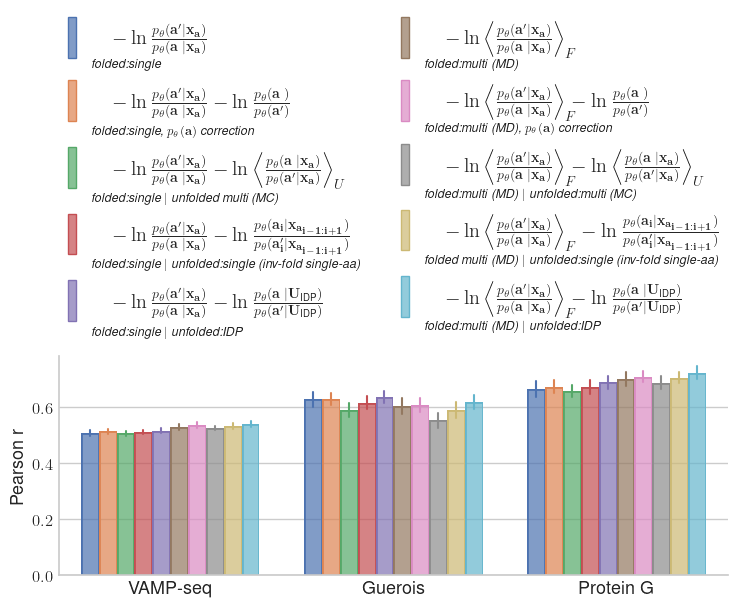

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_figure1(correlation_df, which_coefficients=['pearson', 'spearman'], simple_legend=False, output_filename_prefix="figure1_vert", top_margin=0.44, figure_height=6):

    colors = ['#DB444B', '#006BA2', '#3EBCD2', '#379A8B', '#EBB434', '#B4BA39', '#9A607F', '#D1B07C']
    saturation = 0.75

    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "sans-serif",
    })
    plt.rc('text.latex', preamble=r'\usepackage{helvet}\usepackage{amstext}')

    sns.set(font_scale = 1.2)
    sns.set_palette(sns.color_palette(colors))
    sns.set_style("whitegrid")

    if len(which_coefficients) == 2:
        if simple_legend:
            fig, axs = plt.subplots(ncols=2, figsize=(7.4, figure_height), sharey=True, squeeze=False)
        else:
            fig, axs = plt.subplots(ncols=2, figsize=(7.4, figure_height), sharey=True, squeeze=False)
    else:
        if simple_legend:
            fig, axs = plt.subplots(ncols=1, figsize=(7.4, figure_height), sharey=True, squeeze=False)
        else:
            fig, axs = plt.subplots(ncols=1, figsize=(7.4, figure_height), sharey=True, squeeze=False)
    axs = axs.ravel()

    correlation_df['r_min'] = correlation_df['r'] - correlation_df['se']
    correlation_df['r_max'] = correlation_df['r'] + correlation_df['se']

    import seaborn.objects as so

    for idx, metric in enumerate(which_coefficients):

        p = (
            so.Plot(data=correlation_df.loc[metric], x="dataset", y="r", ymin='r_min', ymax='r_max', color="strategy")
            .add(so.Bar(), so.Dodge())
            .add(so.Range(), so.Dodge())
            .on(axs[idx])
            .plot()
        )
        sns.despine(ax=axs[idx])
        axs[idx].set_xlabel('')
        axs[idx].set_ylabel('')
        if len(which_coefficients) > 1:
            axs[idx].set_xlabel(f'{metric.capitalize()}', fontsize=13)
            if idx==0:  
                axs[0].set_ylabel('r', fontsize=13)
        else:
            if idx==0:  
                axs[0].set_ylabel(f'{metric.capitalize()} r', fontsize=13)
        legend = fig.legends.pop(0)

        if idx==0:
            axs[idx].tick_params(axis='y', which='major', labelbottom = True, bottom=False, top = False, labeltop=False, pad=-2, labelsize=12)
        else:
            axs[idx].tick_params(axis='y', which='major', labelleft=False, labelbottom = False, bottom=False, top = False, labeltop=False, pad=-2, labelsize=12)                

        axs[idx].tick_params(axis='x', which='major', labelbottom = True, bottom=False, top = False, labeltop=False, pad=-2, labelsize=13)

        if idx==0:    
            if len(which_coefficients) == 2:
                if simple_legend:
                    axs[idx].legend(legend.legend_handles, [t.get_text() for t in legend.texts], loc='lower center',  bbox_to_anchor=(1.05, 1.0), ncol=2, frameon=False, fontsize='small', handleheight=2.75, handlelength=0.4, columnspacing=3)
                else:
                    axs[idx].legend(legend.legend_handles, [t.get_text() for t in legend.texts], loc='lower center',  bbox_to_anchor=(1.05, 1.0), ncol=2, frameon=False, fontsize='medium', handleheight=2.75, handlelength=0.4)
            else:
                if simple_legend:
                    axs[idx].legend(legend.legend_handles, [t.get_text() for t in legend.texts], loc='lower center',  bbox_to_anchor=(0.5, 1.0), ncol=2, frameon=False, fontsize='small', handleheight=2.75, handlelength=0.4, columnspacing=3)
                else:
                    axs[idx].legend(legend.legend_handles, [t.get_text() for t in legend.texts], loc='lower center',  bbox_to_anchor=(0.5, 1.0), ncol=2, frameon=False, fontsize='medium', handleheight=2.75, handlelength=0.4)

    if not simple_legend:
        plt.subplots_adjust(left=0.075, right=0.98, bottom=0.075, top=top_margin, wspace = 0.05)
    else:
        plt.subplots_adjust(left=0.075, right=0.98, bottom=0.1, top=top_margin, wspace = 0.05)

    del correlation_df['r_min']
    del correlation_df['r_max']

    plt.savefig(output_filename_prefix+'.pdf')
    plt.savefig(output_filename_prefix+'.svg')

plot_figure1(correlation_df_relabeled, which_coefficients=['pearson'])

### Spearman correlation plot for supporting material

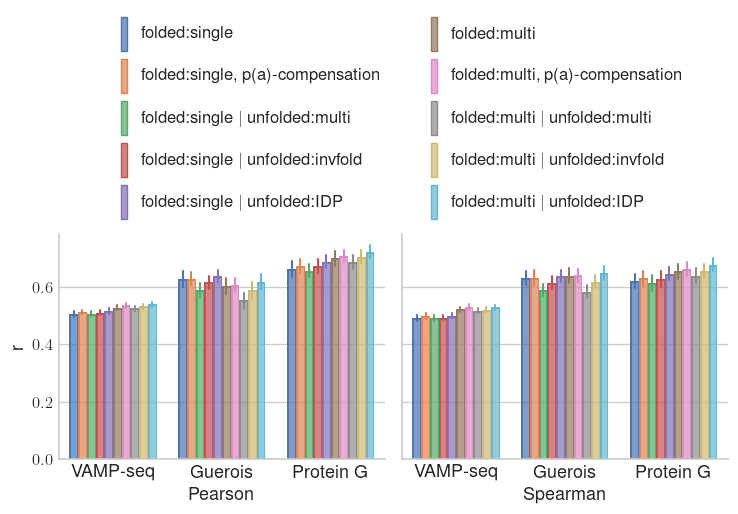

In [17]:
correlation_df_supp_mat = correlation_df_relabeled_names.replace(to_replace={r"\|":r"$|$"}, regex=True)
plot_figure1(correlation_df_supp_mat, which_coefficients=['pearson', 'spearman'], simple_legend=True, output_filename_prefix="figure1_pearson_vs_spearman", top_margin=0.55, figure_height=5)

### Different choices of p(a) compensation

,dataset,strategy,r,se
metric,,,,
pearson,VAMP-seq,"folded:single, $p(a)$-compensation",0.512732,0.009112
pearson,VAMP-seq,"folded:single, $p_{ESM2}(a)$-compensation",0.591662,0.007693
pearson,VAMP-seq,"folded:multi, $p(a)$-compensation",0.536139,0.008341
pearson,VAMP-seq,"folded:multi, $p_{ESM2}(a)$-compensation",0.596449,0.008427
pearson,Guerois,"folded:single, $p(a)$-compensation",0.628951,0.020164
pearson,Guerois,"folded:single, $p_{ESM2}(a)$-compensation",0.594028,0.025634
pearson,Guerois,"folded:multi, $p(a)$-compensation",0.606413,0.026292
pearson,Guerois,"folded:multi, $p_{ESM2}(a)$-compensation",0.553224,0.025943
pearson,Protein G,"folded:single, $p(a)$-compensation",0.673630,0.021432


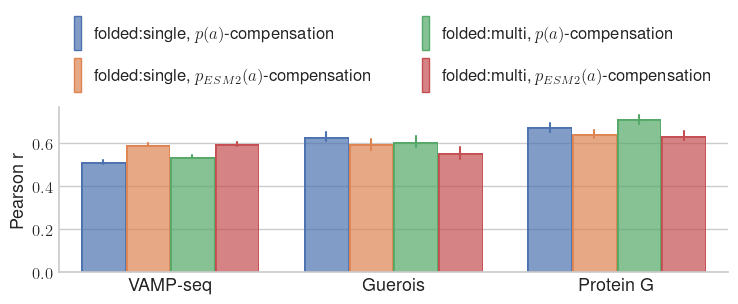

In [18]:
# 2x2 bars for each of the 3 cases. Show as a mini version of Fig 1
correlation_df_mini = calculate_correlations(ddgs, 
                                             ['folded:single, p(a)-compensation', 'folded:single, p_ESM2(a)-compensation',
                                              'folded:multi, p(a)-compensation',  'folded:multi, p_ESM2(a)-compensation'])
correlation_df_mini = correlation_df_mini.replace(to_replace={r"p\(a\)":r"$p(a)$", r"p_ESM2\(a\)":r"$p_{ESM2}(a)$"}, regex=True)
correlation_df_mini = correlation_df_mini.replace(to_replace={'dataset': name_mapping['dataset']})
plot_figure1(correlation_df_mini, which_coefficients=['pearson'], simple_legend=True, output_filename_prefix="p_a_compensation", top_margin=0.65, figure_height=3)
correlation_df_mini

## Sequence-only results (no inverse-folding model)

In [19]:
correlation_df = calculate_correlations(ddgs, 
                                        ['folded:single', 'folded:single | unfolded:multi', 'folded:single | unfolded:invfold', 'folded:single | unfolded:IDP', 
                                         'folded:multi',  'folded:multi | unfolded:multi',  'folded:multi | unfolded:invfold',  'folded:multi | unfolded:IDP',   
                                         'folded:single, p(a)-compensation', 'folded:multi, p(a)-compensation', 
                                         'folded:single, p_ESM2(a)-compensation', 'folded:multi, p_ESM2(a)-compensation', 
                                         'folded:p(a)', 'folded:p(a) | unfolded:multi', 'folded:p(a) | unfolded:invfold', 'folded:p(a) | unfolded:IDP',
                                         'folded:p_ESM2(a)', 'folded:p_ESM2(a) | unfolded:multi', 'folded:p_ESM2(a) | unfolded:invfold', 'folded:p_ESM2(a) | unfolded:IDP'])

correlation_df = correlation_df.replace(to_replace={'dataset': name_mapping['dataset']})

correlation_df_table = correlation_df.copy()
correlation_df_table = correlation_df_table.loc['pearson',:]  # Consider only Pearson in table
correlation_df_table['r'] = correlation_df_table.pop('r').round(2).astype(str) + ' (' + correlation_df_table.pop('se').round(2).astype(str) + ')' 

# Bug in pandas with unstack(sort=False). Workaround: save order and sort afterwards
strategy_order = correlation_df_table['strategy'].drop_duplicates()
correlation_df_table = correlation_df_table.set_index(['dataset', 'strategy']).unstack('dataset')
correlation_df_table = correlation_df_table.reindex(strategy_order, level='strategy')

correlation_df_table


r                           
dataset                                     Guerois     Protein G     VAMP-seq
strategy                                                                      
folded:single                           0.63 (0.02)   0.66 (0.02)  0.51 (0.01)
folded:single | unfolded:multi          0.59 (0.02)   0.66 (0.02)  0.51 (0.01)
folded:single | unfolded:invfold        0.62 (0.02)   0.67 (0.02)  0.51 (0.01)
folded:single | unfolded:IDP            0.64 (0.02)   0.69 (0.02)  0.52 (0.01)
folded:multi                             0.6 (0.03)    0.7 (0.02)  0.53 (0.01)
folded:multi | unfolded:multi           0.55 (0.03)   0.69 (0.02)  0.53 (0.01)
folded:multi | unfolded:invfold         0.59 (0.03)   0.71 (0.02)  0.53 (0.01)
folded:multi | unfolded:IDP             0.62 (0.03)   0.72 (0.03)  0.54 (0.01)
folded:single, p(a)-compensation        0.63 (0.02)   0.67 (0.02)  0.51 (0.01)
folded:multi, p(a)-compensation         0.61 (0.03)   0.71 (0.02)  0.54 (0.01)
folded:single, p_ESM2(a)-compensation   0.59 (0.02)   0.64 (0.02)  0.59 (0.01)
folded:multi, p_ESM2(a)-compensation    0.55 (0.03)   0.63 (0.02)   0.6 (0.01)
folded:p(a)                             0.05 (0.04)   0.12 (0.03)  0.09 (0.01)
folded:p(a) | unfolded:multi           -0.04 (0.03)  -0.04 (0.04)  0.05 (0.01)
folded:p(a) | unfolded:invfold         -0.08 (0.04)  -0.01 (0.04)  0.01 (0.01)
folded:p(a) | unfolded:IDP              0.14 (0.04)   0.21 (0.04)  0.12 (0.01)
folded:p_ESM2(a)                        0.38 (0.03)   0.41 (0.03)  0.49 (0.01)
folded:p_ESM2(a) | unfolded:multi       0.34 (0.03)   0.37 (0.03)  0.48 (0.01)
folded:p_ESM2(a) | unfolded:invfold     0.35 (0.03)   0.39 (0.03)  0.46 (0.01)
folded:p_ESM2(a) | unfolded:IDP          0.4 (0.03)   0.45 (0.03)   0.5 (0.01)

In [20]:
# Report in one big table showing all results - completing discussion of the 3 experimental cases

correlation_df_table = correlation_df.copy()
correlation_df_table = correlation_df_table.loc['pearson',:]  # Consider only Pearson in table
correlation_df_table['r'] = correlation_df_table.pop('r').round(2).astype(str) + ' (' + correlation_df_table.pop('se').round(2).astype(str) + ')' 

# Reorganize tabel
correlation_df_table = correlation_df_table.set_index(['dataset', 'strategy']).unstack(0).swaplevel(axis=1).sort_index(axis=1).droplevel(-1, axis=1)
correlation_df_table = correlation_df_table.reindex(strategy_order, level='strategy')
correlation_df_table.index = correlation_df_table.index.str.split(r'|', expand=True)

# Replace NAs with '' and remove unnecessary column name
correlation_df_table = correlation_df_table.fillna('')
correlation_df_table.columns.name = None
correlation_df_table.index = pd.MultiIndex.from_tuples(
    [tuple('' if pd.isna(x) else x.strip() for x in tup) for tup in correlation_df_table.index]
)
print(correlation_df_table.to_latex())
correlation_df_table


\begin{tabular}{lllll}
\toprule
 &  & Guerois & Protein G & VAMP-seq \\
\midrule
\multirow[t]{4}{*}{folded:single} &  & 0.63 (0.02) & 0.66 (0.02) & 0.51 (0.01) \\
 & unfolded:multi & 0.59 (0.02) & 0.66 (0.02) & 0.51 (0.01) \\
 & unfolded:invfold & 0.62 (0.02) & 0.67 (0.02) & 0.51 (0.01) \\
 & unfolded:IDP & 0.64 (0.02) & 0.69 (0.02) & 0.52 (0.01) \\
\cline{1-5}
\multirow[t]{4}{*}{folded:multi} &  & 0.6 (0.03) & 0.7 (0.02) & 0.53 (0.01) \\
 & unfolded:multi & 0.55 (0.03) & 0.69 (0.02) & 0.53 (0.01) \\
 & unfolded:invfold & 0.59 (0.03) & 0.71 (0.02) & 0.53 (0.01) \\
 & unfolded:IDP & 0.62 (0.03) & 0.72 (0.03) & 0.54 (0.01) \\
\cline{1-5}
folded:single, p(a)-compensation &  & 0.63 (0.02) & 0.67 (0.02) & 0.51 (0.01) \\
\cline{1-5}
folded:multi, p(a)-compensation &  & 0.61 (0.03) & 0.71 (0.02) & 0.54 (0.01) \\
\cline{1-5}
folded:single, p_ESM2(a)-compensation &  & 0.59 (0.02) & 0.64 (0.02) & 0.59 (0.01) \\
\cline{1-5}
folded:multi, p_ESM2(a)-compensation &  & 0.55 (0.03) & 0.63 (0.02) & 0.6

Guerois  \
folded:single                                            0.63 (0.02)   
                                      unfolded:multi     0.59 (0.02)   
                                      unfolded:invfold   0.62 (0.02)   
                                      unfolded:IDP       0.64 (0.02)   
folded:multi                                              0.6 (0.03)   
                                      unfolded:multi     0.55 (0.03)   
                                      unfolded:invfold   0.59 (0.03)   
                                      unfolded:IDP       0.62 (0.03)   
folded:single, p(a)-compensation                         0.63 (0.02)   
folded:multi, p(a)-compensation                          0.61 (0.03)   
folded:single, p_ESM2(a)-compensation                    0.59 (0.02)   
folded:multi, p_ESM2(a)-compensation                     0.55 (0.03)   
folded:p(a)                                              0.05 (0.04)   
                                      unfolded:multi    -0.04 (0.03)   
                                      unfolded:invfold  -0.08 (0.04)   
                                      unfolded:IDP       0.14 (0.04)   
folded:p_ESM2(a)                                         0.38 (0.03)   
                                      unfolded:multi     0.34 (0.03)   
                                      unfolded:invfold   0.35 (0.03)   
                                      unfolded:IDP        0.4 (0.03)   

                                                           Protein G  \
folded:single                                            0.66 (0.02)   
                                      unfolded:multi     0.66 (0.02)   
                                      unfolded:invfold   0.67 (0.02)   
                                      unfolded:IDP       0.69 (0.02)   
folded:multi                                              0.7 (0.02)   
                                      unfolded:multi     0.69 (0.02)   
                                      unfolded:invfold   0.71 (0.02)   
                                      unfolded:IDP       0.72 (0.03)   
folded:single, p(a)-compensation                         0.67 (0.02)   
folded:multi, p(a)-compensation                          0.71 (0.02)   
folded:single, p_ESM2(a)-compensation                    0.64 (0.02)   
folded:multi, p_ESM2(a)-compensation                     0.63 (0.02)   
folded:p(a)                                              0.12 (0.03)   
                                      unfolded:multi    -0.04 (0.04)   
                                      unfolded:invfold  -0.01 (0.04)   
                                      unfolded:IDP       0.21 (0.04)   
folded:p_ESM2(a)                                         0.41 (0.03)   
                                      unfolded:multi     0.37 (0.03)   
                                      unfolded:invfold   0.39 (0.03)   
                                      unfolded:IDP       0.45 (0.03)   

                                                           VAMP-seq  
folded:single                                           0.51 (0.01)  
                                      unfolded:multi    0.51 (0.01)  
                                      unfolded:invfold  0.51 (0.01)  
                                      unfolded:IDP      0.52 (0.01)  
folded:multi                                            0.53 (0.01)  
                                      unfolded:multi    0.53 (0.01)  
                                      unfolded:invfold  0.53 (0.01)  
                                      unfolded:IDP      0.54 (0.01)  
folded:single, p(a)-compensation                        0.51 (0.01)  
folded:multi, p(a)-compensation                         0.54 (0.01)  
folded:single, p_ESM2(a)-compensation                   0.59 (0.01)  
folded:multi, p_ESM2(a)-compensation                     0.6 (0.01)  
folded:p(a)                                             0.09 (0.01)  
                                      unfolded:multi   

## Ablations: Alternative inverse-folding model (ProteinMPNN) and alternative ensemble generator (BioEmu)

### ProteinMPNN

In [21]:
import likelihoods_proteinmpnn
from protein_mpnn_utils import ProteinMPNN

import torch

use_cache = True

model_mpnn = None
if not use_cache:
    # Create MPNN_model
    model_name = "v_48_020"
    model_path_dir = "ProteinMPNN/vanilla_model_weights"
    checkpoint_path = model_path_dir + f'/{model_name}.pt'
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)

    hidden_dim = 128
    num_layers = 3
    backbone_noise = 0.0

    model_mpnn = ProteinMPNN(ca_only=False, num_letters=21, node_features=hidden_dim, edge_features=hidden_dim, hidden_dim=hidden_dim, num_encoder_layers=num_layers, num_decoder_layers=num_layers, augment_eps=backbone_noise, k_neighbors=checkpoint['num_edges'])

# Single sample results
results_single_sample_mpnn = calculate_single_sample_results(
    {k:v for k,v in ddg_data_dict.items() if k=='protein_g'}, # Only consider ProteinG
    partial(likelihoods_proteinmpnn.calc_likelihoods, model),
    output_file_prefixer = lambda ddg_data_key, structure_filename: f"mpnn_{ddg_data_key}_",
    pdb_dict=pdb_dict, use_cache=use_cache)

# Multi sample (MD) results
results_md_mpnn = calculate_multi_sample_results(
    {k:v for k,v in ddg_data_dict.items() if k=='protein_g'}, 
    partial(likelihoods_proteinmpnn.calc_likelihoods, model),
    output_file_prefixer = lambda ddg_data_key, structure_filename: 
        f"mpnn_{ddg_data_key}_" if not "molecular_dynamics" in structure_filename else f"mpnn_{ddg_data_key}_md_",
    pdb_dict=md_pdb_dict, use_cache=True)

# Unfolded state: multiple samples
results_unfolded_mpnn = calculate_unfolded_results(
    {k:v for k,v in ddg_data_dict.items() if k=='protein_g'}, 
    partial(likelihoods_proteinmpnn.calc_likelihoods, model),
    output_file_prefixer = lambda ddg_data_key, structure_filename: 
        f'mpnn_{ddg_data_key}_unfolded_{structure_filename}_',
    use_cache=True)

# Unfolded state: single sample (fragment of wildtype)
results_unfolded_single_sample_mpnn = calculate_unfolded_single_sample_results(
    {k:v for k,v in ddg_data_dict.items() if k=='protein_g'}, 
    partial(likelihoods_esm_if.calc_likelihoods, model, alphabet),
    output_file_prefixer = lambda ddg_data_key, structure_filename: 
        f'mpnn_{ddg_data_key}_unfolded_',
    use_cache=True) 


# Postprocess data
df_single_mpnn = postprocess_single(results_single_sample_mpnn, prediction_label='MPNN')
df_multi_mpnn = postprocess_md(results_md_mpnn, prediction_label='MPNN')
df_unfolded_mpnn = postprocess_unfolded(results_unfolded_mpnn, prediction_label='MPNN')
df_unfolded_single_mpnn = postprocess_unfolded_single(results_unfolded_single_sample_mpnn, prediction_label='MPNN')

# remove filename from index
df_multi_mpnn = df_multi_mpnn.reset_index(3)
df_unfolded_mpnn = df_unfolded_mpnn.reset_index(3)
df_unfolded_single_mpnn = df_unfolded_single_mpnn.reset_index(3)


ddgs_mpnn = df_single_mpnn['ddg'].to_frame('ddg')

# Simple likelihood ratio
ddgs_mpnn['folded:single'] = -(df_single_mpnn['logp_mt'] - df_single_mpnn['logp_wt'])

# Compensation with p(a)
variants_mpnn = pd.Series(df_single_mpnn.index.get_level_values(2), index=df_single_mpnn.index)
logp_a_mt = variants_mpnn.str[-1].transform(lambda aa: np.log(human_proteome_aa_dist[aa]))
logp_a_wt = variants_mpnn.str[0].transform(lambda aa: np.log(human_proteome_aa_dist[aa]))
ddgs_mpnn['p(a)-compensation'] = (logp_a_wt - logp_a_mt)
ddgs_mpnn['folded:single, p(a)-compensation'] = ddgs_mpnn['folded:single'] - ddgs_mpnn['p(a)-compensation']

# Multi-sample approximation to the expectation
ddgs_mpnn['folded:multi'] = ((-(df_multi_mpnn['logp_mt'] - df_multi_mpnn['logp_wt']))
                            .groupby(df_multi_mpnn.index).agg(
                                            lambda g:scipy.special.logsumexp(g) - np.log(len(g))))
ddgs_mpnn['folded:multi, p(a)-compensation'] = ddgs_mpnn['folded:multi'] - ddgs_mpnn['p(a)-compensation']

# Simple likelihood ratio, unfolded (using inverse-folding on fragment of native)
ddgs_mpnn['unfolded:invfold'] = -(df_unfolded_single_mpnn['logp_mt'] - df_unfolded_single_mpnn['logp_wt'])
ddgs_mpnn['folded:single | unfolded:invfold'] = ddgs_mpnn['folded:single'] - ddgs_mpnn['unfolded:invfold']
ddgs_mpnn['folded:multi | unfolded:invfold'] = ddgs_mpnn['folded:multi'] - ddgs_mpnn['unfolded:invfold']

# Sampling from the unfolded state (MCMC)
ddgs_mpnn['unfolded:multi'] = (-(df_unfolded_mpnn['logp_mt'] - df_unfolded_mpnn['logp_wt'])
                            .groupby(df_unfolded_mpnn.index).agg(
                                            lambda g:scipy.special.logsumexp(g) - np.log(len(g))))
ddgs_mpnn['folded:single | unfolded:multi'] = ddgs_mpnn['folded:single'] - ddgs_mpnn['unfolded:multi']
ddgs_mpnn['folded:multi | unfolded:multi'] = ddgs_mpnn['folded:multi'] - ddgs_mpnn['unfolded:multi']

# Unfolded state using IDP stats
logp_a_mt_idp = variants_mpnn.str[-1].transform(lambda aa: np.log(idp_aa_stats[aa]))
logp_a_wt_idp = variants_mpnn.str[0].transform(lambda aa: np.log(idp_aa_stats[aa]))
ddgs_mpnn['folded:single | unfolded:IDP'] = ddgs_mpnn['folded:single'] - (logp_a_wt_idp - logp_a_mt_idp)
ddgs_mpnn['folded:multi | unfolded:IDP'] = ddgs_mpnn['folded:multi'] - (logp_a_wt_idp - logp_a_mt_idp)


# Compensation with "better" p(a) - ESM2
ddgs_mpnn['p_ESM2(a)'] = -(df_seq_only['logp_mt'] - df_seq_only['logp_wt'])
ddgs_mpnn['folded:single, p_ESM2(a)-compensation'] = ddgs_mpnn['folded:single'] - (-ddgs_mpnn['p_ESM2(a)'])
ddgs_mpnn['folded:multi, p_ESM2(a)-compensation'] = ddgs_mpnn['folded:multi'] - (-ddgs_mpnn['p_ESM2(a)'])

correlation_df_mpnn = calculate_correlations(ddgs_mpnn, 
                                        ['folded:single', 'folded:single, p(a)-compensation', 'folded:single | unfolded:multi', 'folded:single | unfolded:invfold', 'folded:single | unfolded:IDP',
                                         'folded:multi',  'folded:multi, p(a)-compensation',  'folded:multi | unfolded:multi',  'folded:multi | unfolded:invfold',  'folded:multi | unfolded:IDP'])

correlation_df_mpnn

,dataset,strategy,r,se
metric,,,,
pearson,protein_g,folded:single,0.396047,0.026764
pearson,protein_g,"folded:single, p(a)-compensation",0.426083,0.024482
pearson,protein_g,folded:single | unfolded:multi,0.391805,0.026836
pearson,protein_g,folded:single | unfolded:invfold,0.349955,0.031806
pearson,protein_g,folded:single | unfolded:IDP,0.475112,0.026622
pearson,protein_g,folded:multi,0.501751,0.020525
pearson,protein_g,"folded:multi, p(a)-compensation",0.528510,0.021250
pearson,protein_g,folded:multi | unfolded:multi,0.485261,0.026816
pearson,protein_g,folded:multi | unfolded:invfold,0.427109,0.025694


### BioEmu (our own runs on ProteinG)

In [22]:
# Read in BioEmu samples
bioemu_pdb_dict = {}
for ddg_key in ['protein_g']:
    bioemu_pdb_dict[ddg_key] = {}
    for path in sorted(glob.glob(f"data/data_{ddg_key}/bioemu_relaxed/*_????.pdb")) + glob.glob(f"data/data_{ddg_key}/pdbs_cleaned/*.pdb"):
        pdb_id = os.path.split(path)[-1].split('_')[0].upper()

        if pdb_id not in bioemu_pdb_dict[ddg_key]:
            bioemu_pdb_dict[ddg_key][pdb_id] = []
        bioemu_pdb_dict[ddg_key][pdb_id].append(path)

# Multi sample (BioEmu) results
results_bioemu = calculate_multi_sample_results(
    {k:v for k,v in ddg_data_dict.items() if k=='protein_g'}, 
    partial(likelihoods_esm_if.calc_likelihoods, model, alphabet),
    output_file_prefixer = lambda ddg_data_key, structure_filename: 
        f"{ddg_data_key}_" if not "bioemu" in structure_filename else f"{ddg_data_key}_bioemu_",
    pdb_dict=bioemu_pdb_dict, use_cache=True)

# Postprocess data
df_multi_bioemu = postprocess_md(results_bioemu, prediction_label="ESM-IF")

# remove filename from index
df_multi_bioemu = df_multi_bioemu.reset_index(3)

# Use main ddg file for static results - using only ProteinG results
ddgs_bioemu = df_single[df_single.index.get_level_values(0) == 'protein_g']['ddg'].to_frame('ddg').copy()
df_single_bioemu = df_single[df_single.index.get_level_values(0) == 'protein_g']
df_unfolded_bioemu = df_unfolded[df_unfolded.index.get_level_values(0) == 'protein_g']
df_unfolded_single_bioemu = df_unfolded_single[df_unfolded_single.index.get_level_values(0) == 'protein_g']



# Simple likelihood ratio
ddgs_bioemu['folded:single'] = -(df_single_bioemu['logp_mt'] - df_single_bioemu['logp_wt'])

# Compensation with p(a)
variants_bioemu = pd.Series(df_single_bioemu.index.get_level_values(2), index=df_single_bioemu.index)
logp_a_mt = variants_bioemu.str[-1].transform(lambda aa: np.log(human_proteome_aa_dist[aa]))
logp_a_wt = variants_bioemu.str[0].transform(lambda aa: np.log(human_proteome_aa_dist[aa]))
ddgs_bioemu['p(a)-compensation'] = (logp_a_wt - logp_a_mt)
ddgs_bioemu['folded:single, p(a)-compensation'] = ddgs_bioemu['folded:single'] - ddgs_bioemu['p(a)-compensation']

# Multi-sample approximation to the expectation
ddgs_bioemu['folded:multi'] = ((-(df_multi_bioemu['logp_mt'] - df_multi_bioemu['logp_wt']))
                            .groupby(df_multi_bioemu.index).agg(
                                            lambda g:scipy.special.logsumexp(g) - np.log(len(g))))
ddgs_bioemu['folded:multi, p(a)-compensation'] = ddgs_bioemu['folded:multi'] - ddgs_bioemu['p(a)-compensation']

# Simple likelihood ratio, unfolded (using inverse-folding on fragment of native)
ddgs_bioemu['unfolded:invfold'] = -(df_unfolded_single_bioemu['logp_mt'] - df_unfolded_single_bioemu['logp_wt'])
ddgs_bioemu['folded:single | unfolded:invfold'] = ddgs_bioemu['folded:single'] - ddgs_bioemu['unfolded:invfold']
ddgs_bioemu['folded:multi | unfolded:invfold'] = ddgs_bioemu['folded:multi'] - ddgs_bioemu['unfolded:invfold']

# Sampling from the unfolded state (MCMC)
ddgs_bioemu['unfolded:multi'] = (-(df_unfolded_bioemu['logp_mt'] - df_unfolded_bioemu['logp_wt'])
                            .groupby(df_unfolded_bioemu.index).agg(
                                            lambda g:scipy.special.logsumexp(g) - np.log(len(g))))
ddgs_bioemu['folded:single | unfolded:multi'] = ddgs_bioemu['folded:single'] - ddgs_bioemu['unfolded:multi']
ddgs_bioemu['folded:multi | unfolded:multi'] = ddgs_bioemu['folded:multi'] - ddgs_bioemu['unfolded:multi']

# Unfolded state using IDP stats
logp_a_mt_idp = variants_bioemu.str[-1].transform(lambda aa: np.log(idp_aa_stats[aa]))
logp_a_wt_idp = variants_bioemu.str[0].transform(lambda aa: np.log(idp_aa_stats[aa]))
ddgs_bioemu['folded:single | unfolded:IDP'] = ddgs_bioemu['folded:single'] - (logp_a_wt_idp - logp_a_mt_idp)
ddgs_bioemu['folded:multi | unfolded:IDP'] = ddgs_bioemu['folded:multi'] - (logp_a_wt_idp - logp_a_mt_idp)


# Compensation with "better" p(a) - ESM2
ddgs_bioemu['p_ESM2(a)'] = -(df_seq_only['logp_mt'] - df_seq_only['logp_wt'])
ddgs_bioemu['folded:single, p_ESM2(a)-compensation'] = ddgs_bioemu['folded:single'] - (-ddgs_bioemu['p_ESM2(a)'])
ddgs_bioemu['folded:multi, p_ESM2(a)-compensation'] = ddgs_bioemu['folded:multi'] - (-ddgs_bioemu['p_ESM2(a)'])


correlation_df_bioemu = calculate_correlations(ddgs_bioemu, 
                                        ['folded:single', 'folded:single, p(a)-compensation', 'folded:single | unfolded:multi', 'folded:single | unfolded:invfold', 'folded:single | unfolded:IDP',
                                         'folded:multi',  'folded:multi, p(a)-compensation',  'folded:multi | unfolded:multi',  'folded:multi | unfolded:invfold',  'folded:multi | unfolded:IDP'])

correlation_df_bioemu

,dataset,strategy,r,se
metric,,,,
pearson,protein_g,folded:single,0.664066,0.019259
pearson,protein_g,"folded:single, p(a)-compensation",0.673630,0.024270
pearson,protein_g,folded:single | unfolded:multi,0.657082,0.021418
pearson,protein_g,folded:single | unfolded:invfold,0.672734,0.024472
pearson,protein_g,folded:single | unfolded:IDP,0.688113,0.023171
pearson,protein_g,folded:multi,0.693910,0.022980
pearson,protein_g,"folded:multi, p(a)-compensation",0.704091,0.022956
pearson,protein_g,folded:multi | unfolded:multi,0.680829,0.019989
pearson,protein_g,folded:multi | unfolded:invfold,0.700543,0.019540


In [23]:
# Organize all ablation results in one table

correlation_df = calculate_correlations(ddgs, 
                                        ['folded:single', 'folded:single, p(a)-compensation', 'folded:single | unfolded:multi', 'folded:single | unfolded:invfold', 'folded:single | unfolded:IDP',
                                         'folded:multi',  'folded:multi, p(a)-compensation',  'folded:multi | unfolded:multi',  'folded:multi | unfolded:invfold',  'folded:multi | unfolded:IDP'])

strategy_order = correlation_df['strategy'].drop_duplicates()

correlation_df_table = correlation_df.copy()
correlation_df_table = correlation_df_table.loc['pearson',:]  # Consider only Pearson in table
correlation_df_table['r'] = correlation_df_table.pop('r').round(2).astype(str) + ' (' + correlation_df_table.pop('se').round(2).astype(str) + ')' 
correlation_df_table = correlation_df_table.set_index(['dataset', 'strategy']).unstack(0).swaplevel(axis=1).sort_index(axis=1).droplevel(-1, axis=1)
correlation_df_table = correlation_df_table.reindex(strategy_order, level='strategy')

correlation_df_table_bioemu = correlation_df_bioemu.copy()
correlation_df_table_bioemu = correlation_df_table_bioemu.loc['pearson',:]  # Consider only Pearson in table
correlation_df_table_bioemu['r'] = correlation_df_table_bioemu.pop('r').round(2).astype(str) + ' (' + correlation_df_table_bioemu.pop('se').round(2).astype(str) + ')' 
correlation_df_table_bioemu = correlation_df_table_bioemu.set_index(['dataset', 'strategy']).unstack(0).swaplevel(axis=1).sort_index(axis=1).droplevel(-1, axis=1)

correlation_df_table_mpnn = correlation_df_mpnn.copy()
correlation_df_table_mpnn = correlation_df_table_mpnn.loc['pearson',:]  # Consider only Pearson in table
correlation_df_table_mpnn['r'] = correlation_df_table_mpnn.pop('r').round(2).astype(str) + ' (' + correlation_df_table_mpnn.pop('se').round(2).astype(str) + ')' 
correlation_df_table_mpnn = correlation_df_table_mpnn.set_index(['dataset', 'strategy']).unstack(0).swaplevel(axis=1).sort_index(axis=1).droplevel(-1, axis=1)
correlation_df_table_mpnn = correlation_df_table_mpnn.reindex(strategy_order, level='strategy')

comparison_table = pd.merge(correlation_df_table['protein_g'].rename('ESM-IF'), correlation_df_table_mpnn.squeeze().rename('MPNN'), left_index=True, right_index=True)

comparison_table['ensemble type'] = ''
comparison_table.loc[comparison_table.index.str.contains('^folded:multi'), 'ensemble type'] = 'MD'

correlation_df_table_bioemu = correlation_df_table_bioemu.rename(columns={'protein_g':'ESM-IF'})
correlation_df_table_bioemu = correlation_df_table_bioemu[correlation_df_table_bioemu.index.str.contains('^folded:multi')]
correlation_df_table_bioemu['ensemble type'] = 'BioEmu'

correlation_table = pd.concat([comparison_table, correlation_df_table_bioemu])
correlation_table = correlation_table.set_index('ensemble type', append=True)

correlation_table = correlation_table.reindex(strategy_order, level='strategy')
print(correlation_table.to_latex())
correlation_table


\begin{tabular}{llll}
\toprule
 &  & ESM-IF & MPNN \\
strategy & ensemble type &  &  \\
\midrule
folded:single &  & 0.66 (0.02) & 0.4 (0.03) \\
\cline{1-4}
folded:single, p(a)-compensation &  & 0.67 (0.02) & 0.43 (0.02) \\
\cline{1-4}
folded:single | unfolded:multi &  & 0.66 (0.02) & 0.39 (0.03) \\
\cline{1-4}
folded:single | unfolded:invfold &  & 0.67 (0.02) & 0.35 (0.03) \\
\cline{1-4}
folded:single | unfolded:IDP &  & 0.69 (0.02) & 0.48 (0.03) \\
\cline{1-4}
\multirow[t]{2}{*}{folded:multi} & MD & 0.7 (0.02) & 0.5 (0.02) \\
 & BioEmu & 0.69 (0.02) & NaN \\
\cline{1-4}
\multirow[t]{2}{*}{folded:multi, p(a)-compensation} & MD & 0.71 (0.02) & 0.53 (0.02) \\
 & BioEmu & 0.7 (0.02) & NaN \\
\cline{1-4}
\multirow[t]{2}{*}{folded:multi | unfolded:multi} & MD & 0.69 (0.02) & 0.49 (0.03) \\
 & BioEmu & 0.68 (0.02) & NaN \\
\cline{1-4}
\multirow[t]{2}{*}{folded:multi | unfolded:invfold} & MD & 0.71 (0.02) & 0.43 (0.03) \\
 & BioEmu & 0.7 (0.02) & NaN \\
\cline{1-4}
\multirow[t]{2}{*}{folded:m

ESM-IF         MPNN
strategy                         ensemble type                          
folded:single                                   0.66 (0.02)   0.4 (0.03)
folded:single, p(a)-compensation                0.67 (0.02)  0.43 (0.02)
folded:single | unfolded:multi                  0.66 (0.02)  0.39 (0.03)
folded:single | unfolded:invfold                0.67 (0.02)  0.35 (0.03)
folded:single | unfolded:IDP                    0.69 (0.02)  0.48 (0.03)
folded:multi                     MD              0.7 (0.02)   0.5 (0.02)
                                 BioEmu         0.69 (0.02)          NaN
folded:multi, p(a)-compensation  MD             0.71 (0.02)  0.53 (0.02)
                                 BioEmu          0.7 (0.02)          NaN
folded:multi | unfolded:multi    MD             0.69 (0.02)  0.49 (0.03)
                                 BioEmu         0.68 (0.02)          NaN
folded:multi | unfolded:invfold  MD             0.71 (0.02)  0.43 (0.03)
                                 BioEmu          0.7 (0.02)          NaN
folded:multi | unfolded:IDP      MD             0.72 (0.02)  0.58 (0.02)
                                 BioEmu         0.72 (0.02)          NaN

## Megascale experimental data

Here, we use the sample data produced by the BioEmu team, as presented in https://zenodo.org/records/15672282 (samples_delta_G.zip). Only the unmutated samples sets were used, and we subsample only 20 molecular conformers from the much larger sets deposited by BioEmu. Finally, the 20 samples were filtered to include only folded states (fraction_native_contacts > 0.5). The native state was defined based on the AlphaFold2 prediction (extracted from ProteinGym).

### The quality of the structure matters

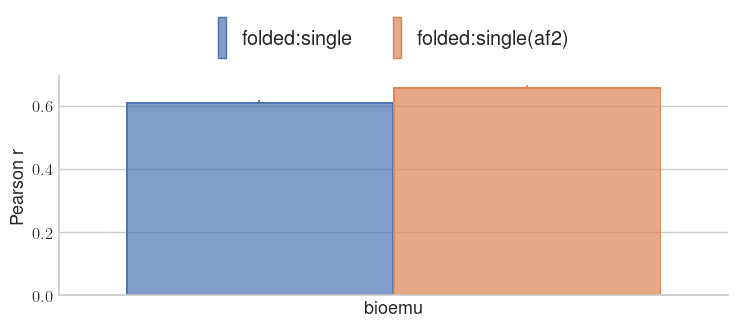

In [24]:
# Read in data
ddg_data_dict_megascale = pd.read_csv("data/data_megascale/ddgs.csv")

# We can use either the AF2 or an ensemble member as "single" structure. This choice matters
pdb_dict_megascale_ensemble_member = {}
pdb_dict_megascale_ensemble_member.update({os.path.split(path)[-1].split('_')[0]: path for path in glob.glob(f"data/data_megascale/bioemu_samples/**/????_0000.pdb", recursive=True)})

pdb_dict_megascale_af2 = {}
pdb_dict_megascale_af2.update({os.path.split(path)[-1].split('_')[0]: path for path in glob.glob(f"data/data_megascale/bioemu_samples/**/????_AF2.pdb", recursive=True)})

# Single sample results - member as single structure
results_single_sample_megascale = calculate_single_sample_results(
    {'bioemu': ddg_data_dict_megascale}, 
    partial(likelihoods_esm_if.calc_likelihoods, model, alphabet),
    output_file_prefixer = lambda ddg_data_key, structure_filename: f"{ddg_data_key}_",
    pdb_dict=pdb_dict_megascale_ensemble_member, use_cache=True)

# Single sample results - AF2 as single structure
results_single_sample_megascale_af2 = calculate_single_sample_results(
    {'bioemu': ddg_data_dict_megascale}, 
    partial(likelihoods_esm_if.calc_likelihoods, model, alphabet),
    output_file_prefixer = lambda ddg_data_key, structure_filename: f"{ddg_data_key}_",
    pdb_dict=pdb_dict_megascale_af2, use_cache=True)

# Postprocess data
df_single_megascale = postprocess_single(results_single_sample_megascale, prediction_label="ESM-IF")
df_single_megascale_af2 = postprocess_single(results_single_sample_megascale_af2, prediction_label="ESM-IF")

# Detect if any datasets have NaNs in them
groups_with_nan = df_single_megascale.groupby('pdbid')['logp_mt'].apply(lambda x: x.isna().any())
groups_with_nan_af2 = df_single_megascale_af2.groupby('pdbid')['logp_mt'].apply(lambda x: x.isna().any())
datasets_with_nan = groups_with_nan[groups_with_nan].index.tolist()
datasets_with_nan_af2 = groups_with_nan[groups_with_nan | groups_with_nan_af2].index.tolist()

# AF2 includes results in more NaNs, so we have to use the stricter mask here
df_single_megascale = df_single_megascale[~df_single_megascale.index.get_level_values('pdbid').isin(datasets_with_nan_af2)]
df_single_megascale_af2 = df_single_megascale_af2[~df_single_megascale_af2.index.get_level_values('pdbid').isin(datasets_with_nan_af2)]

ddgs_megascale = df_single_megascale

# Simple likelihood ratio
ddgs_megascale['folded:single'] = -(df_single_megascale['logp_mt'] - df_single_megascale['logp_wt'])
ddgs_megascale['folded:single(af2)'] = -(df_single_megascale_af2['logp_mt'] - df_single_megascale_af2['logp_wt'])

correlation_df_megascale = calculate_correlations(ddgs_megascale, 
                                                  ['folded:single', 'folded:single(af2)'], flip_sign=True)

plot_figure1(correlation_df_megascale, ['pearson'])

In [25]:
import fraction_native_contacts as fnc
import mdtraj

# Read in data
ddg_data_dict_megascale = pd.read_csv("data/data_megascale/ddgs.csv")

# There are (at least) two ways of doing this comparison to avoid the structural quality of
# the structures dominating the signal: either 1) use an ensemble member as the "single" structure, and then 
# compare with the full ensemble, or 2) use the AF2 structure as the single structure and then include the
# AF2 structure as part of the ensemble. Option 2) gave some technical difficulties, as not all the same
# residues were present in the two structures, and we therefore follow option 1 here.

# Approach 2)
# Single structures (the AF2 structure).
# pdb_dict_megascale = {}
# pdb_dict_megascale.update({os.path.split(path)[-1].split('_')[0]: path for path in glob.glob(f"data/data_megascale/bioemu_samples/**/????_AF2.pdb", recursive=True)})

# # Ensembles
# sample_pdb_dict_megascale = {'bioemu': {}}
# for pdb_id, path in [(os.path.split(path)[-1].split('_')[0], path) for path in sorted(glob.glob(f"data/data_megascale/bioemu_samples/**/????_????.pdb", recursive=True) + glob.glob(f"data/data_megascale/bioemu_samples/**/????_AF2.pdb", recursive=True))]:
#     sample_pdb_dict_megascale['bioemu'].setdefault(pdb_id, [])
#     sample_pdb_dict_megascale['bioemu'][pdb_id].append(path)

def filter_out_unfolded(pdb_filename_list, pdb_reference, fnc_threshold=0.5):
    pdb_filename_list_filtered = []
    for pdb_filename in pdb_filename_list:
        native_contacts = fnc.fraction_native_contacts(mdtraj.load(pdb_reference), mdtraj.load(pdb_filename))
        if native_contacts >= fnc_threshold:
            pdb_filename_list_filtered.append(pdb_filename)
        else:
            print("Filtered out: ", pdb_filename, native_contacts)
    
    return pdb_filename_list_filtered

pdb_dict_megascale_af2 = {os.path.split(path)[-1].split('_')[0]: path for path in glob.glob(f"data/data_megascale/bioemu_samples/**/????_AF2.pdb", recursive=True)}

# Single structures (just the first structure in the ensemble)
pdb_dict_megascale = {}

# Ensembles
total = 0
filtered_total = 0
sample_pdb_dict_megascale = {'bioemu': {}}
for directory in sorted(glob.glob(f"data/data_megascale/bioemu_samples/**")):
    pdb_id = os.path.split(directory)[-1]
    paths = sorted(glob.glob(f"data/data_megascale/bioemu_samples/{pdb_id}/????_????.pdb"))
    paths_filtered = filter_out_unfolded(paths, pdb_dict_megascale_af2[pdb_id])
    total += len(paths)
    filtered_total += len(paths_filtered)
    for path in paths_filtered:
        sample_pdb_dict_megascale['bioemu'].setdefault(pdb_id, [])
        sample_pdb_dict_megascale['bioemu'][pdb_id].append(path)

    if len(paths_filtered) > 0:
        # As the single structure reference, use the first structure in the ensemble
        pdb_dict_megascale[pdb_id] = paths_filtered[0]
    else:
        print("Removed entry with only low FNC values: ", pdb_id)
        ddg_data_dict_megascale = ddg_data_dict_megascale.drop(
            ddg_data_dict_megascale[ddg_data_dict_megascale['pdbid'] == pdb_id].index)

# Single sample results
results_single_sample_megascale = calculate_single_sample_results(
    {'bioemu': ddg_data_dict_megascale}, 
    partial(likelihoods_esm_if.calc_likelihoods, model, alphabet),
    output_file_prefixer = lambda ddg_data_key, structure_filename: f"{ddg_data_key}_",
    pdb_dict=pdb_dict_megascale, use_cache=True)

# Multi sample (MD) results
results_bioemu_megascale = calculate_multi_sample_results(
    {'bioemu': ddg_data_dict_megascale}, 
    partial(likelihoods_esm_if.calc_likelihoods, model, alphabet),
    output_file_prefixer = lambda ddg_data_key, structure_filename: f"{ddg_data_key}_",
    pdb_dict=sample_pdb_dict_megascale, use_cache=True)

# Postprocess data
df_single_megascale = postprocess_single(results_single_sample_megascale, prediction_label="ESM-IF")
df_multi_megascale = postprocess_md(results_bioemu_megascale, prediction_label="ESM-IF")

# Detect if any datasets have NaNs in them
groups_with_nan = df_multi_megascale.groupby('pdbid')['logp_mt'].apply(lambda x: x.isna().any())
groups_with_nan = groups_with_nan[groups_with_nan]  # keep only True
datasets_with_nan = groups_with_nan.index.tolist()

df_single_megascale = df_single_megascale[~df_single_megascale.index.get_level_values('pdbid').isin(datasets_with_nan)]
df_multi_megascale = df_multi_megascale[~df_multi_megascale.index.get_level_values('pdbid').isin(datasets_with_nan)]
print("Removed datasets with NaN values", datasets_with_nan)

# remove filename from index
df_multi_megascale = df_multi_megascale.reset_index(3)

ddgs_megascale = df_single_megascale

# Simple likelihood ratio
ddgs_megascale['folded:single'] = -(df_single_megascale['logp_mt'] - df_single_megascale['logp_wt'])

# Compensation with p(a)
variants_megascale = pd.Series(df_single_megascale.index.get_level_values(2), index=df_single_megascale.index)
logp_a_mt = variants_megascale.str[-1].transform(lambda aa: np.log(human_proteome_aa_dist[aa]))
logp_a_wt = variants_megascale.str[0].transform(lambda aa: np.log(human_proteome_aa_dist[aa]))
ddgs_megascale['p(a)-compensation'] = (logp_a_wt - logp_a_mt)
ddgs_megascale['folded:single, p(a)-compensation'] = ddgs_megascale['folded:single'] - ddgs_megascale['p(a)-compensation']

# Multi-sample approximation to the expectation
ddgs_megascale['folded:multi'] = ((-(df_multi_megascale['logp_mt'] - df_multi_megascale['logp_wt']))
                            .groupby(df_multi_megascale.index).agg(
                                            lambda g:scipy.special.logsumexp(g) - np.log(len(g))))
ddgs_megascale['folded:multi, p(a)-compensation'] = ddgs_megascale['folded:multi'] - ddgs_megascale['p(a)-compensation']

# Unfolded state using IDP stats
logp_a_mt_idp = variants_megascale.str[-1].transform(lambda aa: np.log(idp_aa_stats[aa]))
logp_a_wt_idp = variants_megascale.str[0].transform(lambda aa: np.log(idp_aa_stats[aa]))
ddgs_megascale['folded:single | unfolded:IDP'] = ddgs_megascale['folded:single'] - (logp_a_wt_idp - logp_a_mt_idp)
ddgs_megascale['folded:multi | unfolded:IDP'] = ddgs_megascale['folded:multi'] - (logp_a_wt_idp - logp_a_mt_idp)

# Compensation with "better" p(a) - ESM2
ddgs_megascale['p_ESM2(a)'] = -(df_seq_only['logp_mt'] - df_seq_only['logp_wt'])
ddgs_megascale['folded:single, p_ESM2(a)-compensation'] = ddgs_megascale['folded:single'] - (-ddgs_megascale['p_ESM2(a)'])
ddgs_megascale['folded:multi, p_ESM2(a)-compensation'] = ddgs_megascale['folded:multi'] - (-ddgs_megascale['p_ESM2(a)'])


correlation_df_megascale = calculate_correlations(ddgs_megascale, 
                                        ['folded:single', 'folded:single | unfolded:IDP',
                                         'folded:multi',  'folded:multi | unfolded:IDP'], flip_sign=True)
                                        # ['folded:single', 'folded:single, p(a)-compensation', 'folded:single | unfolded:IDP',
                                        #  'folded:multi',  'folded:multi, p(a)-compensation',  'folded:multi | unfolded:IDP'])
correlation_df_megascale_per_pdb = calculate_correlations(ddgs_megascale, 
                                        ['folded:single', 'folded:single | unfolded:IDP',
                                         'folded:multi',  'folded:multi | unfolded:IDP'],
                                        # ['folded:single', 'folded:single, p(a)-compensation', 'folded:single | unfolded:IDP',
                                        #  'folded:multi',  'folded:multi, p(a)-compensation',  'folded:multi | unfolded:IDP'],
                                         per_pdb=True, flip_sign=True)

correlation_df_megascale = correlation_df_megascale.replace(to_replace={r"\|":r"$|$"}, regex=True)
correlation_df_megascale_per_pdb = correlation_df_megascale_per_pdb.replace(to_replace={r"\|":r"$|$"}, regex=True)

print(correlation_df_megascale)


Filtered out:  data/data_megascale/bioemu_samples/2KFV/2KFV_0002.pdb [0.49662162]
Filtered out:  data/data_megascale/bioemu_samples/2QFF/2QFF_0011.pdb [0.4952381]
Filtered out:  data/data_megascale/bioemu_samples/3DKM/3DKM_0013.pdb [0.48664688]
Removed datasets with NaN values ['2KR3', '2L7F', '2LVN', '2M8I', '3MYC', '4UZW', '6ACV']
         dataset                        strategy         r        se
metric                                                              
pearson   bioemu                   folded:single  0.609184  0.003853
pearson   bioemu  folded:single $|$ unfolded:IDP  0.660482  0.003250
pearson   bioemu                    folded:multi  0.649356  0.003189
pearson   bioemu   folded:multi $|$ unfolded:IDP  0.696774  0.003010
spearman  bioemu                   folded:single  0.571281  0.003620
spearman  bioemu  folded:single $|$ unfolded:IDP  0.620338  0.003177
spearman  bioemu                    folded:multi  0.618972  0.003194
spearman  bioemu   folded:multi $|$ unfolded

### Megascale overview plot

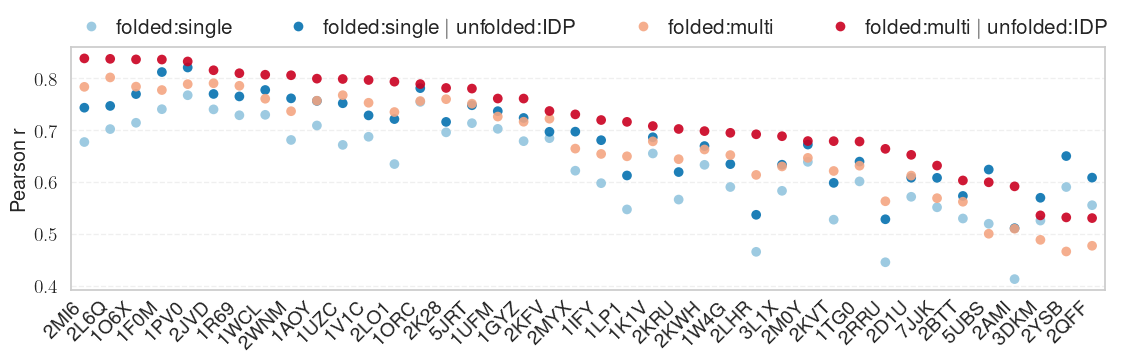

In [26]:
def plot_figure2(correlation_df):

    # colors = ['#DB444B', '#006BA2', '#3EBCD2', '#379A8B', '#EBB434', '#B4BA39', '#9A607F', '#D1B07C']
    colors = [ '#92c5de', '#0571b0', '#f4a582', '#ca0020']
    saturation = 0.75

    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "sans-serif",
    })
    plt.rc('text.latex', preamble=r'\usepackage{helvet}\usepackage{amstext}')


    # Procedure to sort by group
    # Add a stable "original position" column so we can preserve within-group order
    df = correlation_df.assign(_pos = range(len(correlation_df)))

    # Group-level key: mean r per dataset (aligned to rows)
    df['_gkey'] = df.groupby('dataset')['r'].transform('last')
    df_sorted = (
        df.sort_values(by=['_gkey', '_pos'], ascending=[False, True], kind='mergesort')
        .drop(columns=['_gkey', '_pos'])
    )

    correlation_df = df_sorted

    sns.set(font_scale = 1.2)
    sns.set_palette(sns.color_palette(colors))
    sns.set_style("whitegrid")

    fig, axs = plt.subplots(ncols=1, figsize=(12,4), sharey=True, squeeze=False)
    axs = axs.ravel()
    ax = axs[0]

    correlation_df['r_min'] = correlation_df['r'] - correlation_df['se']
    correlation_df['r_max'] = correlation_df['r'] + correlation_df['se']

    metric = 'pearson'

    # Plot all points within group above eachother
    x = sns.stripplot(
        data=correlation_df, x='dataset', y='r',
        hue='strategy', dodge=False, jitter=False,
        marker='o', alpha=0.9, size=7
    )
    ax.set_xlabel('')
    ax.set_ylabel('Pearson r')
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)

    ax.legend(title=None, bbox_to_anchor=(0.5, 1.20), loc='upper center', ncol=4, columnspacing=2.2, fontsize=15, handletextpad=0.2, frameon=False)

    for label in ax.get_xticklabels():
        label.set_rotation(45)      # angle in degrees
        label.set_ha('right')       # horizontal alignment for better readability


    ax.tick_params(axis='x', labelsize=14, pad=0)
    ax.tick_params(axis='y', labelsize=14)

    plt.tight_layout()
    del correlation_df['r_min']
    del correlation_df['r_max']

    plt.savefig('figure2.pdf')
    plt.savefig('figure2.svg')
    plt.show()

plot_figure2(correlation_df_megascale_per_pdb.loc['pearson'].reset_index())